# start

Few shot class incremental learning

In [ ]:
from google.colab import drive
#drive.mount("/content/gdrive/", force_remount=True)
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [138]:
import os
!ls
#root_path = 'gdrive/My Drive/PhD/kksFiles' #phd/FSL_Model_keras'
root_path = 'kks' #gdrive/My Drive/phd' #kks' #
print(os.getcwd())
os.chdir(root_path)
!ls
#jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888  --NotebookApp.port_retries=0
#Moreover We show that the overall common feature can be taken as dummy class for cluster boundary smoothing which improves the generalization.

/bin/bash: /home/kks/miniconda3/envs/kkgpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 accCUB200_PICAMP.pdf   data			 Model
 accPICAMP.pdf	        Data_miniImageNet	 models
 accPICAMP.png	        IECS.ipynb		 PICOMP
 accPICOMP.svg	        images			 PICOMP1
 alpha_variation.pdf   'Incremental FSL.ipynb'	 pseudo_exemplar_FSCIL_v2.ipynb
 best_model.h5	        itrScatterPlot.pdf	 setup_variation.pdf
 CEC-CVPR2021	        Itr_variation.pdf	 TEEN-main
 confusionMatrix1.pdf   logPlot.pdf		 varyingShot1.pdf
 confusionMatrix.pdf    logs
 cub200		        lookAhead.pdf
/home/kks/kks


FileNotFoundError: [Errno 2] No such file or directory: 'kks'

# import

In [139]:
import tensorflow as tf
import math
import pickle
import cv2
import matplotlib.pyplot as plt
import os
import keras
import numpy as np
import numpy.random as rng
import random
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Sequential,load_model, Model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers as rg
from tensorflow.keras import callbacks as cb
from tensorflow.keras.initializers import RandomNormal
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Initialization

In [140]:
def proto_dist(x):  # Negative softmax distance measure
    feature, pred = x
    feature = tf.convert_to_tensor(feature)
    pred = tf.convert_to_tensor(pred)
    pred_dist = tf.reduce_sum(pred ** 2, axis=1, keepdims=True)
    feature_dist = tf.reduce_sum(feature ** 2, axis=1, keepdims=True)
    #print(pred_dist.shape);  print(feature_dist.shape)
    dot = tf.matmul(pred, tf.transpose(feature))
    #print(dot.shape)
    return tf.nn.softmax(-(tf.sqrt(pred_dist + tf.transpose(feature_dist) - 2 * dot)))

def cosine_distances(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance


def saveData(data,file_name):
  open_file = open(file_name, "wb")
  pickle.dump(data, open_file)
  open_file.close()
def loadData(file_name):
  open_file = open(file_name, "rb")
  dt = pickle.load(open_file)
  open_file.close()
  return dt


def proto_dist1(x):  # Negative softmax distance measure
    feature, pred = x
    feature = tf.convert_to_tensor(feature)
    pred = tf.convert_to_tensor(pred)
    pred_dist = tf.reduce_sum(pred ** 2, axis=1, keepdims=True)
    feature_dist = tf.reduce_sum(feature ** 2, axis=1, keepdims=True)
    dot = tf.matmul(pred, tf.transpose(feature))
    return tf.sqrt(pred_dist + tf.transpose(feature_dist) - 2 * dot)


# load dataset

In [141]:
X_train1 = loadData('data/miniImageNet.pkl')
cifar100 = loadData('data/cifar100.pkl')
#cub200 = loadData('data/cub200.pkl')

In [ ]:
del cifar100, cub200

## miniImageNet

In [ ]:
import pandas as pd
df = pd.read_pickle("Data_miniImageNet/mini-imagenet-cache-train.pkl")
x_train = np.array(df['image_data']); y_train = df['class_dict']
x_train = np.reshape(x_train,(-1,84,84,3)).astype('float32')
df = pd.read_pickle("Data_miniImageNet/mini-imagenet-cache-val.pkl")
x_val = df['image_data']; y_val = df['class_dict']
x_val = np.reshape(x_val,(-1,84,84,3)).astype('float32')
df = pd.read_pickle("Data_miniImageNet/mini-imagenet-cache-test.pkl")
x_test = df['image_data']; y_test = df['class_dict']
x_test = np.reshape(x_test,(-1,84,84,3)).astype('float32')
#.....................................................................
x_train = x_train/255 #
print(x_train.shape, len(y_train))
x_val = x_val/255
print(x_val.shape, len(y_val))
x_test  = x_test/255
print(x_test.shape, len(y_test))
#..............................................................
xT= np.reshape(x_train, (64,600,84,84,3))
xv= np.reshape(x_val, (16,600,84,84,3))
xt= np.reshape(x_test, (20,600,84,84,3))

X_train1= np.vstack([xT,xv, xt])
print(X_train1.shape)

del x_train, x_val, x_test, xT,xv,xt,df

(38400, 84, 84, 3) 64
(9600, 84, 84, 3) 16
(12000, 84, 84, 3) 20
(100, 600, 84, 84, 3)


In [ ]:
#saveData(X_train1,'data/miniImageNet.pkl')


(100, 600, 84, 84, 3)


## cifar100

In [ ]:
from tensorflow.keras.datasets import cifar100
# Load CIFAR-100 dataset
(x_trainCipher, y_trainCipher), (x_testCipher, y_testCipher) = cifar100.load_data()

# Normalize the pixel values between 0 and 1
x_trainCipher = x_trainCipher.astype('float32') / 255.0
x_testCipher = x_testCipher.astype('float32') / 255.0

# Check dataset shape
print(f"Training data shape: {x_trainCipher.shape}, Training labels shape: {y_trainCipher.shape}")
print(f"Test data shape: {x_testCipher.shape}, Test labels shape: {y_testCipher.shape}")
X_trainC1= np.vstack([x_trainCipher,x_testCipher])
Y_trainC= np.vstack([y_trainCipher,y_testCipher])
sorted_train_indices = np.argsort(Y_trainC.flatten())
X_trainC = X_trainC1[sorted_train_indices]
y_Cipher = Y_trainC[sorted_train_indices]

X_trainC= np.reshape(X_trainC, (-1,600,32,32,3))
print(X_trainC.shape)
#del x_trainCipher, x_testCipher, y_trainCipher,y_testCipher

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)
(100, 600, 32, 32, 3)


In [ ]:

saveData(X_trainC,'data/cifar100.pkl')
print(np.array(cifar100).shape)

(100, 600, 32, 32, 3)


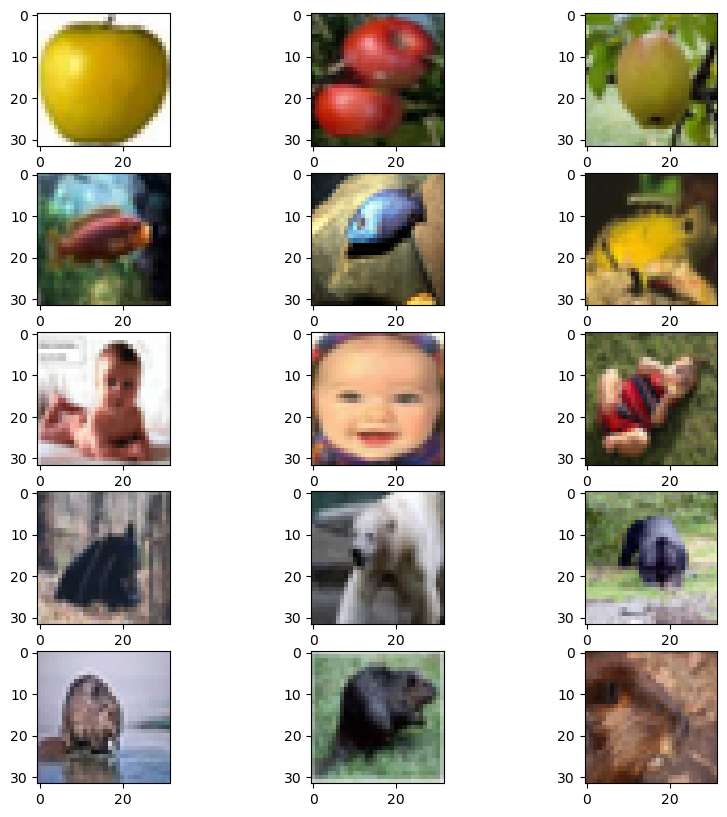

In [ ]:
k=3
plt.figure(figsize=(10,10))
a=[0,500,599]
for i in range(5):
  for j in range(k):
    plt.subplot(5,k,i*k+j+1)
    plt.imshow(X_trainC[i,a[j],:,:,:])
plt.show( )

## CUB200

In [ ]:
# cd cub200/
!ls
# !tar -xvzf CUB_200.tgz

/bin/bash: /home/kks/miniconda3/envs/kkgpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 accPICAMP.pdf	 confusionMatrix.pdf	  Model
 accPICAMP.png	 cub_200		  pseudo_exemplar_FSCIL_v2.ipynb
 accPICOMP.pdf	 CUB_200.tgz		  TEEN-main
 accPICOMP.png	 Data_miniImageNet	  th_α_variation.pdf
 accPICOMP.svg	 IECS.ipynb		  varyingShot.pdf
 best_model.h5	'Incremental FSL.ipynb'   withinPICAMP.pdf
 CEC-CVPR2021	 logs


In [ ]:
# cub_200=train_images #np.hstack([train_images,test_images])
# print(np.array(cub_200).shape)
# saveData(cub_200,'data/cub200.pkl')
cub_200=loadData('data/cub200.pkl')
print(np.array(cub_200).shape)

(200, 60, 224, 224, 3)


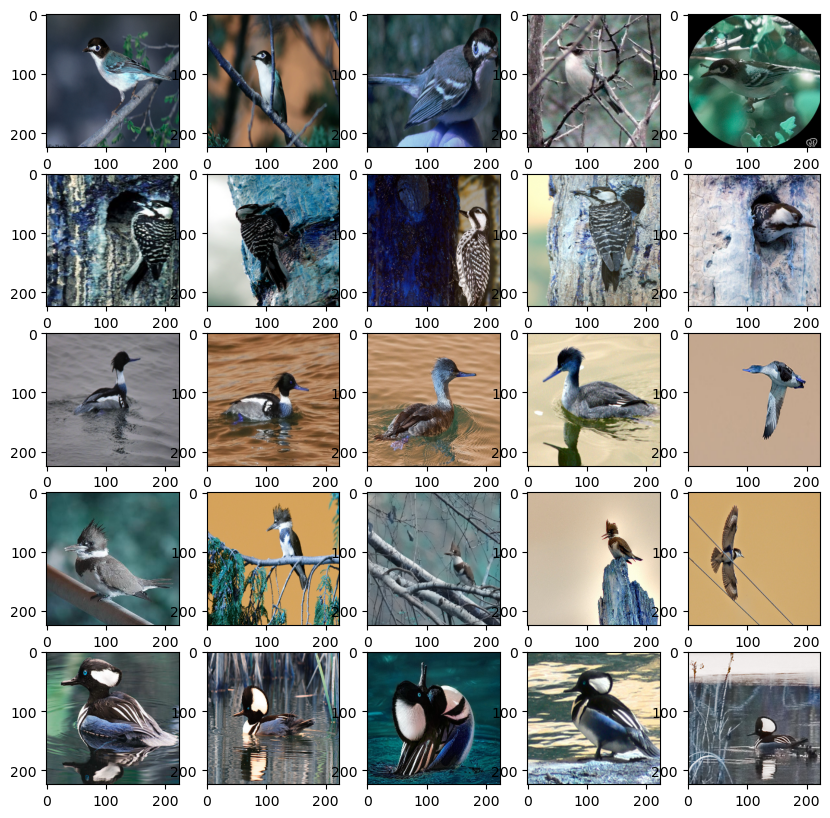

In [ ]:
k=5
plt.figure(figsize=(10,10))
for i in range(5):
  for j in range(k):
    plt.subplot(5,k,i*k+j+1)
    plt.imshow(cub_200[i][j])
plt.show( )


In [ ]:
from tqdm import tqdm
def loader(path=None):
    train_images = [];
    folders_list = os.listdir(path);
    print("folder1:", len(folders_list))
    count = 0;
    for folder in tqdm(folders_list):
        path1 = os.path.join(path, folder)
        print("folder2:",len(os.listdir(path1)))
        try:
          train_images1=[];
          for image_name in os.listdir(path1):
              image1 = cv2.imread(os.path.join(path1, image_name))
              image= cv2.resize(image1, (256,256)) #224,224.. 256-16*2=224
              image=image[16:-16,16:-16]
              train_images1.append(image)
              count = count +1
          L = len(train_images1)
          for j in range(60-L):
                train_images1.append(train_images1[-1])
          train_images.append(train_images1)
        except NotADirectoryError:
            print(f"Cannot load from {path1}")
    print("count:",count)
    return train_images

train_images = loader(path="cub200/CUB_200_2011/images")
print(np.array(train_images).shape)



folder1: 200


  0%|▏                                          | 1/200 [00:00<00:20,  9.72it/s]

folder2: 51
folder2: 58


  2%|▋                                          | 3/200 [00:00<00:27,  7.07it/s]

folder2: 60
folder2: 60


  2%|█                                          | 5/200 [00:00<00:28,  6.80it/s]

folder2: 60
folder2: 60


  4%|█▌                                         | 7/200 [00:01<00:29,  6.62it/s]

folder2: 59
folder2: 59


  4%|█▉                                         | 9/200 [00:01<00:29,  6.40it/s]

folder2: 60
folder2: 56


  6%|██▎                                       | 11/200 [00:01<00:28,  6.63it/s]

folder2: 60
folder2: 60


  6%|██▋                                       | 13/200 [00:01<00:27,  6.75it/s]

folder2: 59
folder2: 60


  8%|███▏                                      | 15/200 [00:02<00:29,  6.24it/s]

folder2: 60
folder2: 60


  8%|███▌                                      | 17/200 [00:02<00:28,  6.49it/s]

folder2: 60
folder2: 60


 10%|███▉                                      | 19/200 [00:02<00:28,  6.27it/s]

folder2: 60
folder2: 60


 10%|████▍                                     | 21/200 [00:03<00:29,  6.04it/s]

folder2: 60
folder2: 60


 12%|████▊                                     | 23/200 [00:03<00:27,  6.41it/s]

folder2: 59
folder2: 60


 12%|█████▎                                    | 25/200 [00:03<00:27,  6.30it/s]

folder2: 60
folder2: 60


 14%|█████▋                                    | 27/200 [00:04<00:27,  6.26it/s]

folder2: 59
folder2: 59


 14%|██████                                    | 29/200 [00:04<00:25,  6.64it/s]

folder2: 60
folder2: 48


 16%|██████▌                                   | 31/200 [00:04<00:23,  7.31it/s]

folder2: 60
folder2: 60


 16%|██████▉                                   | 33/200 [00:05<00:24,  6.77it/s]

folder2: 60
folder2: 59


 18%|███████▎                                  | 35/200 [00:05<00:25,  6.51it/s]

folder2: 60
folder2: 50


 18%|███████▊                                  | 37/200 [00:05<00:24,  6.72it/s]

folder2: 60
folder2: 59


 20%|████████▏                                 | 39/200 [00:05<00:22,  7.08it/s]

folder2: 60
folder2: 59


 20%|████████▌                                 | 41/200 [00:06<00:21,  7.32it/s]

folder2: 53
folder2: 60


 22%|█████████                                 | 43/200 [00:06<00:21,  7.33it/s]

folder2: 60
folder2: 60


 22%|█████████▍                                | 45/200 [00:06<00:21,  7.18it/s]

folder2: 59
folder2: 59


 24%|█████████▊                                | 47/200 [00:07<00:22,  6.74it/s]

folder2: 60
folder2: 60


 24%|██████████▎                               | 49/200 [00:07<00:23,  6.48it/s]

folder2: 60
folder2: 60


 26%|██████████▋                               | 51/200 [00:07<00:21,  6.87it/s]

folder2: 50
folder2: 60


 26%|███████████▏                              | 53/200 [00:07<00:22,  6.53it/s]

folder2: 60
folder2: 59


 28%|███████████▌                              | 55/200 [00:08<00:22,  6.42it/s]

folder2: 60
folder2: 60


 28%|███████████▉                              | 57/200 [00:08<00:24,  5.94it/s]

folder2: 60
folder2: 59


 30%|████████████▍                             | 59/200 [00:08<00:23,  5.95it/s]

folder2: 60
folder2: 60


 30%|████████████▊                             | 61/200 [00:09<00:22,  6.12it/s]

folder2: 60
folder2: 59


 32%|█████████████▏                            | 63/200 [00:09<00:21,  6.29it/s]

folder2: 60
folder2: 60


 32%|█████████████▋                            | 65/200 [00:09<00:21,  6.27it/s]

folder2: 60
folder2: 56


 34%|██████████████                            | 67/200 [00:10<00:20,  6.48it/s]

folder2: 60
folder2: 60


 34%|██████████████▍                           | 69/200 [00:10<00:20,  6.38it/s]

folder2: 60
folder2: 60


 36%|██████████████▉                           | 71/200 [00:10<00:19,  6.51it/s]

folder2: 59
folder2: 59


 36%|███████████████▎                          | 73/200 [00:11<00:18,  6.79it/s]

folder2: 59
folder2: 60


 38%|███████████████▊                          | 75/200 [00:11<00:18,  6.78it/s]

folder2: 60
folder2: 59


 38%|████████████████▏                         | 77/200 [00:11<00:18,  6.70it/s]

folder2: 60
folder2: 60


 40%|████████████████▌                         | 79/200 [00:12<00:18,  6.44it/s]

folder2: 60
folder2: 60


 40%|█████████████████                         | 81/200 [00:12<00:17,  6.69it/s]

folder2: 59
folder2: 60


 42%|█████████████████▍                        | 83/200 [00:12<00:18,  6.20it/s]

folder2: 59
folder2: 60


 42%|█████████████████▊                        | 85/200 [00:12<00:17,  6.63it/s]

folder2: 60
folder2: 60


 44%|██████████████████▎                       | 87/200 [00:13<00:15,  7.22it/s]

folder2: 60
folder2: 60


 44%|██████████████████▋                       | 89/200 [00:13<00:16,  6.83it/s]

folder2: 60
folder2: 60


 46%|███████████████████                       | 91/200 [00:13<00:16,  6.67it/s]

folder2: 59
folder2: 60


 46%|███████████████████▌                      | 93/200 [00:14<00:16,  6.48it/s]

folder2: 60
folder2: 60


 48%|███████████████████▉                      | 95/200 [00:14<00:16,  6.39it/s]

folder2: 60
folder2: 60


 48%|████████████████████▎                     | 97/200 [00:14<00:15,  6.44it/s]

folder2: 60
folder2: 60


 50%|████████████████████▊                     | 99/200 [00:15<00:15,  6.62it/s]

folder2: 58
folder2: 56


 50%|████████████████████▋                    | 101/200 [00:15<00:14,  6.92it/s]

folder2: 59
folder2: 50


 52%|█████████████████████                    | 103/200 [00:15<00:13,  7.42it/s]

folder2: 60
folder2: 60


 52%|█████████████████████▌                   | 105/200 [00:15<00:14,  6.72it/s]

folder2: 60
folder2: 58


 54%|█████████████████████▉                   | 107/200 [00:16<00:13,  6.74it/s]

folder2: 60
folder2: 60


 55%|██████████████████████▎                  | 109/200 [00:16<00:13,  6.57it/s]

folder2: 60
folder2: 60


 56%|██████████████████████▊                  | 111/200 [00:16<00:13,  6.50it/s]

folder2: 60
folder2: 60


 56%|██████████████████████▉                  | 112/200 [00:16<00:13,  6.56it/s]

folder2: 41
folder2: 59


 57%|███████████████████████▌                 | 115/200 [00:17<00:10,  7.78it/s]

folder2: 60
folder2: 60


 58%|███████████████████████▉                 | 117/200 [00:17<00:11,  7.36it/s]

folder2: 60
folder2: 49


 60%|████████████████████████▍                | 119/200 [00:17<00:10,  7.37it/s]

folder2: 60
folder2: 59


 60%|████████████████████████▊                | 121/200 [00:18<00:10,  7.25it/s]

folder2: 60
folder2: 60


 62%|█████████████████████████▏               | 123/200 [00:18<00:10,  7.31it/s]

folder2: 60
folder2: 45
folder2: 60


 63%|█████████████████████████▊               | 126/200 [00:18<00:10,  7.31it/s]

folder2: 60
folder2: 60


 64%|██████████████████████████▏              | 128/200 [00:19<00:10,  6.76it/s]

folder2: 60
folder2: 60


 65%|██████████████████████████▋              | 130/200 [00:19<00:10,  6.89it/s]

folder2: 59
folder2: 60


 66%|██████████████████████████▊              | 131/200 [00:19<00:10,  6.87it/s]

folder2: 53
folder2: 60


 66%|███████████████████████████▎             | 133/200 [00:19<00:08,  7.86it/s]

folder2: 52
folder2: 60


 68%|███████████████████████████▉             | 136/200 [00:20<00:08,  7.55it/s]

folder2: 60
folder2: 60


 69%|████████████████████████████▎            | 138/200 [00:20<00:08,  7.04it/s]

folder2: 60
folder2: 59


 70%|████████████████████████████▋            | 140/200 [00:20<00:09,  6.61it/s]

folder2: 60
folder2: 60


 71%|█████████████████████████████            | 142/200 [00:21<00:09,  6.16it/s]

folder2: 58
folder2: 60


 72%|█████████████████████████████▌           | 144/200 [00:21<00:08,  6.56it/s]

folder2: 58
folder2: 60


 73%|█████████████████████████████▉           | 146/200 [00:21<00:07,  6.80it/s]

folder2: 60
folder2: 57


 74%|██████████████████████████████▎          | 148/200 [00:22<00:07,  6.64it/s]

folder2: 60
folder2: 60


 75%|██████████████████████████████▊          | 150/200 [00:22<00:07,  6.42it/s]

folder2: 60
folder2: 60


 76%|███████████████████████████████▏         | 152/200 [00:22<00:07,  6.46it/s]

folder2: 60
folder2: 60


 77%|███████████████████████████████▌         | 154/200 [00:22<00:07,  6.38it/s]

folder2: 60
folder2: 60


 78%|███████████████████████████████▉         | 156/200 [00:23<00:06,  6.49it/s]

folder2: 60
folder2: 60


 79%|████████████████████████████████▍        | 158/200 [00:23<00:06,  6.50it/s]

folder2: 60
folder2: 60


 80%|████████████████████████████████▊        | 160/200 [00:23<00:06,  6.10it/s]

folder2: 60
folder2: 60


 81%|█████████████████████████████████▏       | 162/200 [00:24<00:06,  6.33it/s]

folder2: 60
folder2: 60


 82%|█████████████████████████████████▌       | 164/200 [00:24<00:05,  6.27it/s]

folder2: 60
folder2: 60


 83%|██████████████████████████████████       | 166/200 [00:24<00:05,  6.39it/s]

folder2: 60
folder2: 60


 84%|██████████████████████████████████▍      | 168/200 [00:25<00:04,  6.45it/s]

folder2: 60
folder2: 60


 85%|██████████████████████████████████▊      | 170/200 [00:25<00:04,  6.48it/s]

folder2: 59
folder2: 53


 86%|███████████████████████████████████▎     | 172/200 [00:25<00:04,  6.78it/s]

folder2: 60
folder2: 60


 87%|███████████████████████████████████▋     | 174/200 [00:26<00:03,  6.53it/s]

folder2: 60
folder2: 58


 88%|███████████████████████████████████▉     | 175/200 [00:26<00:03,  6.36it/s]

folder2: 50
folder2: 60


 89%|████████████████████████████████████▍    | 178/200 [00:26<00:03,  6.94it/s]

folder2: 60
folder2: 60


 90%|████████████████████████████████████▉    | 180/200 [00:26<00:03,  6.63it/s]

folder2: 59
folder2: 60


 91%|█████████████████████████████████████▎   | 182/200 [00:27<00:02,  6.97it/s]

folder2: 60
folder2: 60


 92%|█████████████████████████████████████▋   | 184/200 [00:27<00:02,  7.34it/s]

folder2: 60
folder2: 60


 93%|██████████████████████████████████████▏  | 186/200 [00:27<00:01,  7.09it/s]

folder2: 60
folder2: 60


 94%|██████████████████████████████████████▌  | 188/200 [00:28<00:01,  6.87it/s]

folder2: 57
folder2: 59


 95%|██████████████████████████████████████▉  | 190/200 [00:28<00:01,  6.75it/s]

folder2: 60
folder2: 59


 96%|███████████████████████████████████████▎ | 192/200 [00:28<00:01,  7.21it/s]

folder2: 60
folder2: 44


 97%|███████████████████████████████████████▊ | 194/200 [00:28<00:00,  7.50it/s]

folder2: 60
folder2: 60


 98%|████████████████████████████████████████▏| 196/200 [00:29<00:00,  6.92it/s]

folder2: 60
folder2: 59


 99%|████████████████████████████████████████▌| 198/200 [00:29<00:00,  6.48it/s]

folder2: 60
folder2: 60


100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.69it/s]


folder2: 60
count: 11788
(200, 60, 224, 224, 3)


In [ ]:
with open('cub200/CUB_200_2011/train_test_split.txt', 'r') as file:
    # Read all lines and strip whitespace
    lines = [line.strip() for line in file.readlines()]

Ind=[]
for v in lines:
  v1=v.split(' ')
  Ind.append(int(v1[1]))
print(Ind)


[0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 

In [ ]:
from tqdm import tqdm
def loader(path=None):
    train_images = []; test_images = [];
    folders_list = os.listdir(path); train_images1=[]
    print("folder1:", len(folders_list))
    count = 0;
    for folder in tqdm(folders_list):
        path1 = os.path.join(path, folder)
        print("folder2:",len(os.listdir(path1)))
        try:
          train_images1=[]; test_images1=[]
          for image_name in os.listdir(path1):
              image1 = cv2.imread(os.path.join(path1, image_name))
              image= cv2.resize(image1, (256,256)) #224,224... 128, 112, 256-224=32
              image=image[16:-16,16:-16]
              if Ind[count]==1:
                train_images1.append(image)
              else:
                test_images1.append(image)
              count = count +1
          for j in range(30-len(train_images1)):
                train_images1.append(train_images1[-1])
          for j in range(30-len(test_images1)):
                test_images1.append(test_images1[-1])
          train_images.append(train_images1)
          test_images.append(test_images1)
          print(len(train_images1), len(test_images1))

        except NotADirectoryError:
            print(f"Cannot load from {path1}")
    print("count:",count)
    return train_images, test_images

train_images, test_images = loader(path="cub200/CUB_200_2011/images")

print(np.array(train_images).shape, np.array(test_images).shape)



folder1: 200


  0%|▏                                          | 1/200 [00:00<00:23,  8.50it/s]

folder2: 51
30 30
folder2: 58


  2%|▋                                          | 3/200 [00:00<00:30,  6.55it/s]

30 30
folder2: 60
33 30
folder2: 60


  2%|█                                          | 5/200 [00:00<00:29,  6.69it/s]

30 30
folder2: 60
40 30
folder2: 60


  4%|█▌                                         | 7/200 [00:01<00:29,  6.50it/s]

41 30
folder2: 59
33 30
folder2: 59


  4%|█▉                                         | 9/200 [00:01<00:30,  6.23it/s]

30 30
folder2: 60
31 30
folder2: 56


  6%|██▎                                       | 11/200 [00:01<00:29,  6.50it/s]

30 30
folder2: 60
33 30
folder2: 60


  6%|██▋                                       | 13/200 [00:01<00:27,  6.71it/s]

30 31
folder2: 59
32 30
folder2: 60


  8%|███▏                                      | 15/200 [00:02<00:28,  6.40it/s]

30 31
folder2: 60
31 30
folder2: 60


  8%|███▌                                      | 17/200 [00:02<00:27,  6.65it/s]

30 30
folder2: 60
38 30
folder2: 60


 10%|███▉                                      | 19/200 [00:02<00:28,  6.42it/s]

31 30
folder2: 60
30 30
folder2: 60


 10%|████▍                                     | 21/200 [00:03<00:29,  6.06it/s]

30 32
folder2: 60
36 30
folder2: 60


 12%|████▊                                     | 23/200 [00:03<00:27,  6.53it/s]

30 30
folder2: 59
34 30
folder2: 60


 12%|█████▎                                    | 25/200 [00:03<00:27,  6.37it/s]

30 30
folder2: 60
30 31
folder2: 60


 14%|█████▋                                    | 27/200 [00:04<00:27,  6.40it/s]

30 30
folder2: 59
33 30
folder2: 59


 14%|██████                                    | 29/200 [00:04<00:25,  6.68it/s]

30 34
folder2: 60
31 30
folder2: 48


 16%|██████▌                                   | 31/200 [00:04<00:23,  7.26it/s]

30 30
folder2: 60
33 30
folder2: 60


 16%|██████▉                                   | 33/200 [00:05<00:25,  6.53it/s]

30 31
folder2: 60
30 32
folder2: 59


 18%|███████▎                                  | 35/200 [00:05<00:26,  6.28it/s]

30 30
folder2: 60
33 30
folder2: 50


 18%|███████▊                                  | 37/200 [00:05<00:25,  6.51it/s]

30 30
folder2: 60
31 30
folder2: 59


 20%|████████▏                                 | 39/200 [00:05<00:23,  6.75it/s]

30 31
folder2: 60
30 32
folder2: 59


 20%|████████▌                                 | 41/200 [00:06<00:22,  6.99it/s]

32 30
folder2: 53
30 30
folder2: 60


 22%|█████████                                 | 43/200 [00:06<00:22,  7.00it/s]

30 30
folder2: 60
30 31
folder2: 60


 22%|█████████▍                                | 45/200 [00:06<00:22,  7.00it/s]

32 30
folder2: 59
30 30
folder2: 59


 24%|█████████▊                                | 47/200 [00:07<00:22,  6.73it/s]

30 30
folder2: 60
31 30
folder2: 60


 24%|██████████▎                               | 49/200 [00:07<00:23,  6.49it/s]

30 31
folder2: 60
30 31
folder2: 60


 26%|██████████▋                               | 51/200 [00:07<00:21,  6.85it/s]

30 30
folder2: 50
30 30
folder2: 60


 26%|███████████▏                              | 53/200 [00:08<00:22,  6.44it/s]

35 30
folder2: 60
30 35
folder2: 59


 28%|███████████▌                              | 55/200 [00:08<00:22,  6.33it/s]

30 30
folder2: 60
31 30
folder2: 60


 28%|███████████▉                              | 57/200 [00:08<00:23,  5.98it/s]

31 30
folder2: 60
31 30
folder2: 59


 30%|████████████▍                             | 59/200 [00:09<00:23,  5.94it/s]

30 30
folder2: 60
31 30
folder2: 60


 30%|████████████▊                             | 61/200 [00:09<00:22,  6.05it/s]

30 32
folder2: 60
32 30
folder2: 59


 32%|█████████████▏                            | 63/200 [00:09<00:22,  6.20it/s]

30 31
folder2: 60
32 30
folder2: 60


 32%|█████████████▋                            | 65/200 [00:10<00:22,  6.13it/s]

32 30
folder2: 60
32 30
folder2: 56


 34%|██████████████                            | 67/200 [00:10<00:20,  6.43it/s]

30 30
folder2: 60
30 30
folder2: 60


 34%|██████████████▍                           | 69/200 [00:10<00:20,  6.31it/s]

32 30
folder2: 60
30 32
folder2: 60


 36%|██████████████▉                           | 71/200 [00:10<00:19,  6.55it/s]

30 30
folder2: 59
31 30
folder2: 59


 36%|███████████████▎                          | 73/200 [00:11<00:19,  6.62it/s]

31 30
folder2: 59
31 30
folder2: 60


 38%|███████████████▊                          | 75/200 [00:11<00:18,  6.69it/s]

31 30
folder2: 60
30 34
folder2: 59


 38%|████████████████▏                         | 77/200 [00:11<00:19,  6.46it/s]

32 30
folder2: 60
30 31
folder2: 60


 40%|████████████████▌                         | 79/200 [00:12<00:19,  6.07it/s]

31 30
folder2: 60
31 30
folder2: 60


 40%|█████████████████                         | 81/200 [00:12<00:18,  6.47it/s]

30 30
folder2: 59
30 31
folder2: 60


 42%|█████████████████▍                        | 83/200 [00:12<00:19,  6.01it/s]

30 32
folder2: 59
36 30
folder2: 60


 42%|█████████████████▊                        | 85/200 [00:13<00:17,  6.42it/s]

30 30
folder2: 60
30 31
folder2: 60


 44%|██████████████████▎                       | 87/200 [00:13<00:16,  6.89it/s]

31 30
folder2: 60
30 32
folder2: 60


 44%|██████████████████▋                       | 89/200 [00:13<00:16,  6.68it/s]

32 30
folder2: 60
30 30
folder2: 60


 46%|███████████████████                       | 91/200 [00:14<00:16,  6.64it/s]

30 30
folder2: 59
30 30
folder2: 60


 46%|███████████████████▌                      | 93/200 [00:14<00:16,  6.44it/s]

30 31
folder2: 60
31 30
folder2: 60


 48%|███████████████████▉                      | 95/200 [00:14<00:16,  6.50it/s]

30 32
folder2: 60
34 30
folder2: 60


 48%|████████████████████▎                     | 97/200 [00:14<00:16,  6.39it/s]

30 31
folder2: 60
30 31
folder2: 60


 50%|████████████████████▊                     | 99/200 [00:15<00:15,  6.67it/s]

30 31
folder2: 58
31 30
folder2: 56


 50%|████████████████████▋                    | 101/200 [00:15<00:14,  6.79it/s]

32 30
folder2: 59
30 30
folder2: 50


 52%|█████████████████████                    | 103/200 [00:15<00:13,  7.15it/s]

30 30
folder2: 60
33 30
folder2: 60


 52%|█████████████████████▌                   | 105/200 [00:16<00:14,  6.39it/s]

34 30
folder2: 60
30 31
folder2: 58


 54%|█████████████████████▉                   | 107/200 [00:16<00:14,  6.35it/s]

30 30
folder2: 60
30 30
folder2: 60


 55%|██████████████████████▎                  | 109/200 [00:16<00:14,  6.14it/s]

30 30
folder2: 60
30 30
folder2: 60


 56%|██████████████████████▊                  | 111/200 [00:17<00:14,  6.23it/s]

30 30
folder2: 60
30 30
folder2: 60


 56%|██████████████████████▉                  | 112/200 [00:17<00:14,  6.27it/s]

33 30
folder2: 41
30 30
folder2: 59


 57%|███████████████████████▌                 | 115/200 [00:17<00:11,  7.38it/s]

30 30
folder2: 60
34 30
folder2: 60


 58%|███████████████████████▉                 | 117/200 [00:17<00:11,  7.01it/s]

30 32
folder2: 60
31 30
folder2: 49


 60%|████████████████████████▍                | 119/200 [00:18<00:11,  7.09it/s]

30 30
folder2: 60
31 30
folder2: 59


 60%|████████████████████████▊                | 121/200 [00:18<00:11,  7.06it/s]

30 33
folder2: 60
32 30
folder2: 60


 62%|█████████████████████████▏               | 123/200 [00:18<00:10,  7.10it/s]

30 31
folder2: 60
31 30
folder2: 45
30 30
folder2: 60


 63%|█████████████████████████▊               | 126/200 [00:19<00:10,  7.17it/s]

30 32
folder2: 60
31 30
folder2: 60


 64%|██████████████████████████▏              | 128/200 [00:19<00:10,  6.56it/s]

33 30
folder2: 60
30 32
folder2: 60


 65%|██████████████████████████▋              | 130/200 [00:19<00:10,  6.64it/s]

31 30
folder2: 59
30 30
folder2: 60


 66%|██████████████████████████▊              | 131/200 [00:19<00:10,  6.62it/s]

33 30
folder2: 53
30 30
folder2: 60


 66%|███████████████████████████▎             | 133/200 [00:20<00:08,  7.73it/s]

30 32
folder2: 52
30 30
folder2: 60


 68%|███████████████████████████▉             | 136/200 [00:20<00:08,  7.39it/s]

30 33
folder2: 60
30 33
folder2: 60


 69%|████████████████████████████▎            | 138/200 [00:20<00:08,  7.00it/s]

32 30
folder2: 60
31 30
folder2: 59


 70%|████████████████████████████▋            | 140/200 [00:21<00:09,  6.53it/s]

30 31
folder2: 60
31 30
folder2: 60


 71%|█████████████████████████████            | 142/200 [00:21<00:09,  6.28it/s]

32 30
folder2: 58
30 34
folder2: 60


 72%|█████████████████████████████▌           | 144/200 [00:21<00:08,  6.77it/s]

36 30
folder2: 58
30 33
folder2: 60


 73%|█████████████████████████████▉           | 146/200 [00:22<00:07,  6.89it/s]

30 30
folder2: 60
31 30
folder2: 57


 74%|██████████████████████████████▎          | 148/200 [00:22<00:07,  6.59it/s]

30 30
folder2: 60
31 30
folder2: 60


 75%|██████████████████████████████▊          | 150/200 [00:22<00:07,  6.39it/s]

31 30
folder2: 60
30 30
folder2: 60


 76%|███████████████████████████████▏         | 152/200 [00:23<00:07,  6.42it/s]

32 30
folder2: 60
31 30
folder2: 60


 77%|███████████████████████████████▌         | 154/200 [00:23<00:07,  6.22it/s]

30 34
folder2: 60
35 30
folder2: 60


 78%|███████████████████████████████▉         | 156/200 [00:23<00:06,  6.31it/s]

31 30
folder2: 60
30 35
folder2: 60


 79%|████████████████████████████████▍        | 158/200 [00:24<00:06,  6.36it/s]

34 30
folder2: 60
31 30
folder2: 60


 80%|████████████████████████████████▊        | 160/200 [00:24<00:06,  6.18it/s]

30 30
folder2: 60
30 30
folder2: 60


 81%|█████████████████████████████████▏       | 162/200 [00:24<00:05,  6.40it/s]

30 31
folder2: 60
30 30
folder2: 60


 82%|█████████████████████████████████▌       | 164/200 [00:24<00:05,  6.53it/s]

30 31
folder2: 60
31 30
folder2: 60


 83%|██████████████████████████████████       | 166/200 [00:25<00:04,  6.81it/s]

31 30
folder2: 60
30 32
folder2: 60


 84%|██████████████████████████████████▍      | 168/200 [00:25<00:04,  6.77it/s]

30 30
folder2: 60
32 30
folder2: 60


 85%|██████████████████████████████████▊      | 170/200 [00:25<00:04,  6.82it/s]

36 30
folder2: 59
30 32
folder2: 53


 86%|███████████████████████████████████▎     | 172/200 [00:26<00:03,  7.28it/s]

30 30
folder2: 60
30 32
folder2: 60


 87%|███████████████████████████████████▋     | 174/200 [00:26<00:03,  6.94it/s]

33 30
folder2: 60
30 31
folder2: 58


 88%|███████████████████████████████████▉     | 175/200 [00:26<00:03,  6.70it/s]

30 30
folder2: 50
30 30
folder2: 60


 89%|████████████████████████████████████▍    | 178/200 [00:26<00:03,  7.20it/s]

31 30
folder2: 60
31 30
folder2: 60


 90%|████████████████████████████████████▉    | 180/200 [00:27<00:02,  6.85it/s]

30 31
folder2: 59
32 30
folder2: 60


 91%|█████████████████████████████████████▎   | 182/200 [00:27<00:02,  7.21it/s]

30 32
folder2: 60
31 30
folder2: 60


 92%|█████████████████████████████████████▋   | 184/200 [00:27<00:02,  7.48it/s]

31 30
folder2: 60
30 31
folder2: 60


 93%|██████████████████████████████████████▏  | 186/200 [00:28<00:01,  7.35it/s]

30 30
folder2: 60
32 30
folder2: 60


 94%|██████████████████████████████████████▌  | 188/200 [00:28<00:01,  7.18it/s]

36 30
folder2: 57
30 30
folder2: 59


 95%|██████████████████████████████████████▉  | 190/200 [00:28<00:01,  7.00it/s]

30 33
folder2: 60
30 31
folder2: 59


 96%|███████████████████████████████████████▎ | 192/200 [00:28<00:01,  7.53it/s]

31 30
folder2: 60
30 30
folder2: 44


 97%|███████████████████████████████████████▊ | 194/200 [00:29<00:00,  7.84it/s]

30 30
folder2: 60
30 30
folder2: 60


 98%|████████████████████████████████████████▏| 196/200 [00:29<00:00,  7.30it/s]

30 30
folder2: 60
30 31
folder2: 59


 99%|████████████████████████████████████████▌| 198/200 [00:29<00:00,  6.82it/s]

30 30
folder2: 60
30 30
folder2: 60


100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.65it/s]

30 30
folder2: 60
30 30
count: 11788


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (200,) + inhomogeneous part.

In [ ]:

conv1 =load_model('Model/resnet18_Classifier_Backbone_cifar100_30_32_50.h5')
print(X_train1.shape)
ctrain0=[];
k=np.array(random.sample(list(np.arange(0,600)), 40))
for i in range(100):
    ctrain0.append( conv1(cifar100[i,k,:,:,:]))

c0 = np.mean(np.reshape(np.array(ctrain0),(-1,2,512)),axis=1)
print(c0.shape)

(100, 600, 84, 84, 3)
(2000, 512) (2000, 512)
(2000, 512)


In [ ]:

def proto_shift1(ctr,ct1):  #prototype spanning
    ct2=ct1; ct=[];
    for i in range(3):
        d2=proto_dist1([ctr,ct2])
        print(tf.argmin(d2, axis=1))
        T=tf.Variable(random.sample([0.8,1.0,1.2],1)[0])
        d3=d2**(1/T)
        score=tf.nn.softmax(-(d3))
        ct2= ct1*0.99 + tf.matmul(score,ctr)*0.01
        ct.append(ct2)
        #print(tf.reduce_min(d2))
        # if(tf.reduce_min(d2)<25 ):
        #    break
    return ct

# tsne

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=42)


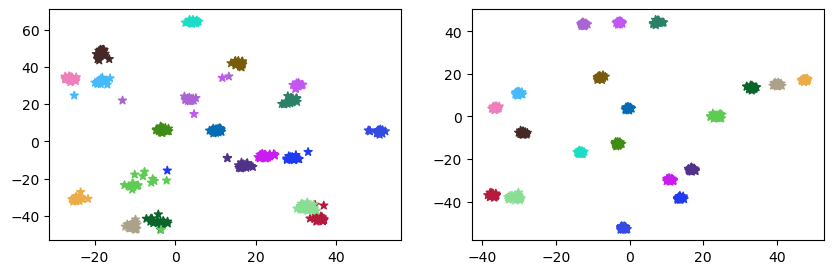

In [ ]:
# p1 = p0 +np.random.normal(0.0,1.0,size=p0.shape)
# #x1 = tsne.fit_transform(c0)
# x2 = tsne.fit_transform(p1)
k=20
colors1=np.repeat(np.random.rand(k, 3), 20,axis=0)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.scatter(x1[:k*20, 0], x1[:k*20, 1], c=colors1,marker='*')

plt.subplot(1,2,2)
plt.scatter(x2[:k*20, 0], x2[:k*20, 1], c=colors1,marker='*')

plt.show()

In [ ]:

cx0=c0[0:60,:]
cx=ctrain1[[65,66],:]
print(cx.shape)
c01=proto_shift1(ctrain1[0:60,:],cx)
c01=np.reshape(np.array(c01),(6,4608))
print(c01.shape)
tsne1 = tsne.fit_transform(np.vstack([ctrain1[0:60,:],cx,c01]))
print(tsne1.shape)

x01 = tsne1[0:60,:]
x11 = tsne1[[60,61],:]
x111 = (tsne1[-6:,:])[[0,2,4,1,3,5],:]


(2, 4608)
tf.Tensor([ 9 17], shape=(2,), dtype=int64)
tf.Tensor([ 9 17], shape=(2,), dtype=int64)
tf.Tensor([ 9 17], shape=(2,), dtype=int64)
(6, 4608)


/home/kks/miniconda3/envs/kkgpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kks/miniconda3/envs/kkgpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(68, 2)


# Calibration and look ahead plot

In [ ]:

#colors=np.repeat(['r','b','g','c','m','olive','brown','yellow','orange','pink'],20)
#colors1=np.repeat(['g','c','m'],10)
colors1=np.repeat(['g'],60)
colors2=np.repeat(['olive','orange'],10)
colors3=np.repeat(['orange','orange'],3)

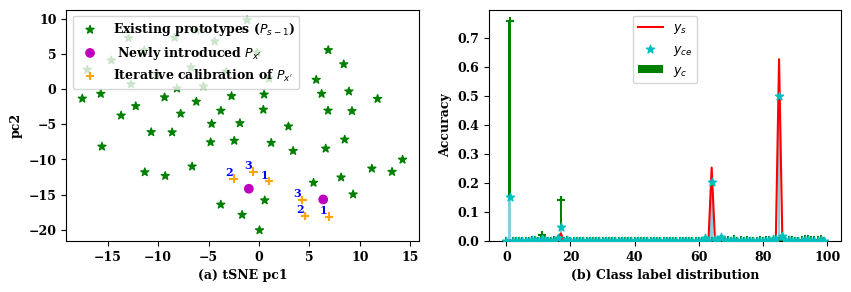

In [ ]:
plt.figure(figsize=(10,3))
plt.rc('font', family='serif', weight='bold', size=9)
plt.subplot(1,2,1)
plt.scatter(x01[:, 0], x01[:, 1], c=colors1,marker='*', label="Existing prototypes ($P_{s-1}$)")
plt.scatter(x11[:, 0], x11[:, 1], c=['m','m'], marker='o', label=" Newly introduced $P_{x'}$")
plt.scatter(x111[:, 0], x111[:, 1], c=colors3,marker='+', label="Iterative calibration of $P_{x'}$")
numbers=[1,2,3,1,2,3]
for i, number in enumerate(numbers):
    plt.text(x111[i,0]- 0.1, x111[i,1]+0.1, str(number), fontsize=8, ha='right', va='bottom', color='b')
plt.xlabel("(a) tSNE pc1",weight='bold');plt.ylabel("pc2",weight='bold')
plt.legend(loc="upper left")

plt.subplot(1,2,2)
plt.plot(ys[i],color='r', label='$y_s$',zorder=5)

plt.bar(np.linspace(0,99,100),yc[i],color='g',label="$y_c$")
plt.scatter(np.linspace(0,99,100),yc[i], marker='+',color='g',zorder=2)

plt.bar(np.linspace(0,99,100),yce[i],color='#87CEE0')
plt.scatter(np.linspace(0,99,100),yce[i], marker='*',color='c',zorder=6,label='$y_{ce}$')

plt.ylabel("Accuracy",weight='bold')
plt.xlabel("(b) Class label distribution", weight='bold')
plt.legend(loc='upper center') #['$y_s$',"$y_c$",'$y_{ce}$' ],
plt.show()

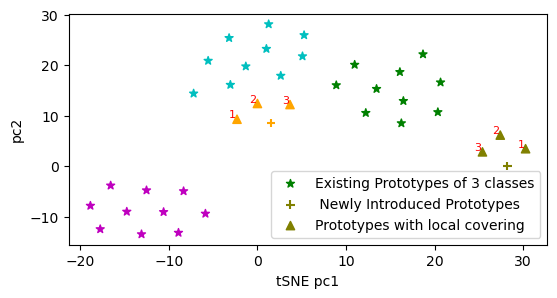

In [ ]:
plt.figure(figsize=(21,3))
plt.subplot(1,3,1)
# plt.scatter(x0[:, 0], x0[:, 1], c=colors1,marker='*')
# plt.scatter(x1[:, 0], x1[:, 1], c=colors2,marker='^')
# plt.subplot(1,3,2)
#x111 = (tsne1[-6:,:])[[0,2,4,1,3,5],:]+np.random.normal(0,0.3,size=(6,2))
plt.scatter(x01[10:40, 0], x01[10:40, 1], c=colors1,marker='*', label="Existing Prototypes of 3 classes")
plt.scatter(x11[:, 0], x11[:, 1], c=['olive','orange'], marker='+', label=" Newly Introduced Prototypes")
plt.scatter(x111[:, 0], x111[:, 1], c=colors3,marker='^', label="Prototypes with local covering")
numbers=[1,2,3,1,2,3]
for i, number in enumerate(numbers):
    plt.text(x111[i,0]- 0.1, x111[i,1]-0.1, str(number), fontsize=8, ha='right', va='bottom', color='red')
plt.xlabel("tSNE pc1");plt.ylabel("pc2")
plt.legend(loc="lower right")
# plt.subplot(1,3,3)
# plt.scatter(x2[:, 0], x2[:, 1], c=colors,marker="*")
plt.show()

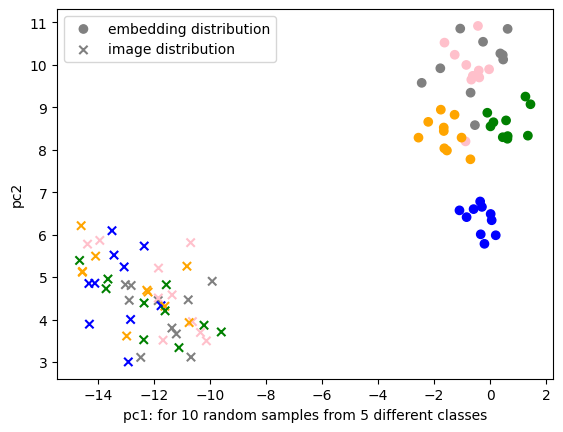

In [ ]:

cc=['gray','pink','b','orange','g']
ccc=np.repeat(cc,10)
#fig, axs=plt.subplots(1, 2, figsize=(12,5))
plt.scatter(X_tsneS1[:, 0], X_tsneS1[:, 1], c=ccc)
plt.scatter(X_tsneS2[:, 0], X_tsneS2[:, 1], c=ccc, marker="x")
plt.ylabel ('pc2')
plt.xlabel ('pc1: for 10 random samples from 5 different classes')
plt.legend(['embedding distribution','image distribution'])
plt.show()
# axs[1].scatter(x=X_tsneS2[:, 0], y=X_tsneS2[:, 1], c=ccc)
# axs[1].scatter(X_tsneQ2[:, 0], X_tsneQ2[:, 1], c=ccc, marker="x")
# axs[0].set_ylabel ('tSNE2')
# axs[1].set_xlabel ('tSNE1:with CS')

# axs[1].scatter(x=X_tsne3[:, 0], y=X_tsne3[:, 1], c=ccc)
# axs[1].set_xlabel ('tSNE1')
plt.show()

# Data Incremental sample generation




In [142]:

class Data_GeneratorIncremental(tf.keras.utils.Sequence):
    def __init__(self, trainData, way = 5,  k1=0,k2=60, k3=0,k4=500, shot = 2, num_batch=1,seed=42,proto=0,all=1):
        self.data = trainData
        n1,n2,n3,n4,n5=trainData.shape
        self.dim=[n3,n4,n5]; self.dimResize=[n3+n3//8,n4+n4//8]
        self.k1=k1; self.k2=k2;self.k3=k3; self.k4=k4
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.way = way
        self.shot = shot
        self.seed = seed
        self.all=all
        self.proto=proto
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'
        X_sample,label= self.__data_generation()
        return X_sample, label

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        X_sample = []; X_sample1 = [];
        label = np.zeros((self.way,self.k2))
        #label = np.zeros((self.way*self.shot,self.k2))

        idx = list(np.arange(self.k1,self.k2))
        if(len(idx)> self.way):
           idx = random.sample(idx, self.way) #selected_classes

        if(self.all==0):
           random.seed(self.seed)
        #print(idx)
        for i in range(len(idx)):
            X_temp = [];
            sample_idx1 = random.sample(list(np.arange(self.k3,self.k4)), self.shot)
            #print(sample_idx1)
            for s in range(self.shot):
              img = self.data[idx[i]][sample_idx1[s]]
              X_sample.append(img)
              image = tf.image.resize(img, self.dimResize)
              imgc = tf.image.random_crop(image, size=self.dim)
              imgf = tf.image.random_flip_left_right(imgc)
              #img1=random.sample([img,imgf], 1)[0]   #np.flip(img,1),random_crop(img)
              X_sample.append(imgf)
              if(self.proto==1):
                X_sample.append(tf.image.random_crop(img, size=self.dim))
              #label[i*self.shot+s,idx[i]]= 1
            label[i,idx[i]]= 1
        #label = np.eye(self.k2)[idx]

        return  np.array(X_sample), label

train_way = 10
shot = 1
seed1 =int(random.uniform(1,100))
trainData =X_train1  #minimageNet
#trainData =X_trainC  ##cipher
#trainData = np.array(cub200)
#val_loader= Data_GeneratorIncremental(trainData, way = train_way, k1=0,k2=65, k3=500, k4=600, shot=shot, num_batch= 5, seed=42, proto=0, all=1)
val_loader=Data_GeneratorIncremental(trainData,way = train_way,k1=60,k2=70, k3=30,k4=60, shot=shot,num_batch=1,all=1)

x, z= val_loader[0]
print(x.shape,  z.shape)
print(z)


(20, 84, 84, 3) (10, 70)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Data generation for Base traning

In [ ]:

class Data_GeneratorClassifier(tf.keras.utils.Sequence):
    def __init__(self, trainData, way = 5,  k1=0,k2=60, k3=0,k4=500, shot = 2, num_batch=1,seed=42,proto=0,all=1):
        self.data = trainData
        n1,n2,n3,n4,n5=trainData.shape
        self.dim=[n3,n4,n5]; self.dimResize=[n3+n3//8,n4+n4//8]

        self.k1=k1; self.k2=k2;self.k3=k3; self.k4=k4
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.way = way
        self.shot = shot
        self.seed=seed
        self.all=all
        self.proto=proto
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'
        X_sample,label= self.__data_generation()
        return X_sample, label

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        X_sample = []; X_sample1 = [];
        label = np.zeros((self.way,self.k2)) #*self.shot
        #label = np.zeros((self.way*self.shot,self.k2))
        idx = list(np.arange(self.k1,self.k2))
        idx = random.sample(idx, self.way) #selected_classes
        #print(idx)
        for i in range(len(idx)):
            X_temp = [];
            sample_idx1 = random.sample(list(np.arange(self.k3,self.k4)), self.shot)
            #print(sample_idx1)
            for s in range(self.shot):
              img = self.data[idx[i]][sample_idx1[s]]
              #X_sample.append(img)
              image = tf.image.resize(img, self.dimResize)
              imgc = tf.image.random_crop(image, size=self.dim)
              imgf = tf.image.random_flip_left_right(imgc)
              img1 = random.sample([img,imgf], 1)[0]   #np.flip(img,1),random_crop(img)
              X_sample.append(img1)
              #label[i*self.shot+s,idx[i]]= 1
            label[i,idx[i]]= 1
            #label = np.eye(self.k2)[idx]
        return  np.array(X_sample), label

train_way = 30
shot = 1

#trainData = np.array(cub200)
trainData = np.array(X_train1)
#trainData = np.array(X_trainC)
val_loader = Data_GeneratorClassifier(trainData,way = train_way, k1=0,k2=60, k3=0, k4=30, shot=shot, num_batch= 5)

x, z= val_loader[0]
print(x.shape,  z.shape)
print(z)


(30, 84, 84, 3) (30, 60)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# ...............................................................

# resNet18 Back bone

In [1]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras_applications
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')

base_model = ResNet18(input_shape=(64,64,3), weights='imagenet',include_top=False)

base_model.summary()


/bin/bash: /home/kks/miniconda3/envs/kkgpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-kw5xbtp7
  ERROR: Error [Errno 2] No such file or directory: 'git' while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
/bin/bash: /home/kks/miniconda3/envs/kkgpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)


2024-11-22 15:56:22.036971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 15:56:22.202400: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 15:56:22.230367: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 15:56:22.710661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 64, 64, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                              

# resnet18 Classification-CIFAR 100

In [ ]:
train_way=30
shot=1
dim=(32,32,3)
lr=0.0001
base_model = ResNet18(input_shape=(128,128,3), weights='imagenet',include_top=False)
#base_model = ResNet18(input_shape=(32,32,3),weights=None,include_top=False)
model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(.3))
model.add(Flatten())
model.build(input_shape=(None, 32, 32, 3))  # Set the input shape
output=model(tf.ones((5, 32, 32, 3)))
model.summary()
resNetClassifier = model # Model(inputs=base_model.input, outputs=out2)  #modelResnet20 #

mydense = Sequential([Dense(60, input_shape=(8192,), name="dense1",activation='linear',use_bias=False)])
#mydense = load_model('Model/resnet18_ClassifierUpsample_mydense_cipher_30_1_32_50.h5')

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr

if __name__ == "__main__":

    input_shape = (32,32,3)
    sample = Input(input_shape)
    out_feature1 = resNetClassifier(sample)
    #out_feature1 = Lambda(reduce_tensor2, name="out_feature1")(out_feature1)
    #.........................................................
    pred1 = mydense(out_feature1)
    # x_normalized = tf.linalg.l2_normalize(out_feature1, axis=-1)
    # weights_normalized = tf.linalg.l2_normalize(wt, axis=-1)
    # pred1 = tf.matmul(x_normalized, mydense.weights)[0]*16

    pred = tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)

    optimizer= Adam(learning_rate=lr)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    #print(resNetProto.summary())
 #.........................................................................................
    trainData = np.array(loadData('data/cifar100.pkl'));
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #batch_size=16,
    history4 = resNetProto.fit(train_loader,epochs = 30, batch_size=32,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])

    resNetClassifier.save('Model/resnet18_Classifier_Backbone_cifar100_30_32_30.h5')
    mydense.save('Model/resnet18_Classifier_mydense_cifar100_30_32_30.h5')



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 64, 64, 3)        0         
 2D)                                                             
                                                                 
 up_sampling2d_5 (UpSampling  (None, 128, 128, 3)      0         
 2D)                                                             
                                                                 
 model_11 (Functional)       (None, 4, 4, 512)         11186889  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
Total params: 11,186,889
Trainable params: 11,178,947
Non-trainable params: 7,942
_________________________________________________________________
Epoch 1/30
100/100 [=================

In [ ]:
resNetClassifier.save('Model/resnet18_Classifier_Backbone_cifar100_30_32_30.h5')
mydense.save('Model/resnet18_Classifier_mydense_cifar100_30_32_30.h5')

In [ ]:
train_way = 30
shot = 1
lr=0.0001
dim=(32,32,3)

#base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False) #,
#out1=tf.keras.layers.Dropout(0.5)(base_model.output)
#out2=tf.keras.layers.Flatten()(base_model.output)
resNetClassifier = model # Model(inputs=base_model.input, outputs=out2)
# resNetClassifier=load_model('Model/resnet18_ClassifierRandomCrop_Backbone_cypher100_30_32_2.h5')
# mydense =load_model('Model/resnet18_ClassifierRandomCrop_mydense_cypher100_30_32_2.h5')
# mydense= load_model('Model/resnet18_ClassifierRandomCrop_mydense_cypher100__30_32.h5')    # classification head of the base model
# resNetClassifier = load_model('Model/resnet18_ClassifierRandomCrop_Backbone_cypher100_30_32.h5')
def reduce_tensor1(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,512)), axis=1)

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr

if __name__ == "__main__":

    input_shape = (32,32,3)
    sample = Input(input_shape)
    mydense = Sequential([Dense(60, input_shape=(512,), name="dense1",activation='linear',use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])
    out_feature1 = resNetClassifier(sample)
    #out_feature1 = Lambda(reduce_tensor1, name="out_feature1")(out_feature1)
    #.........................................................
    pred1 = mydense(out_feature1)

    pred = tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)

    # early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
    # model_checkpoint = callbacks.ModelCheckpoint('best_classifierCipher.h5', save_best_only=True)
    optimizer = Adam(0.0001)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetProto.summary())
 #.........................................................................................
    train_loader = Data_GeneratorClassifier(way = train_way,  data ='cipher', k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifierTest(way = train_way,  data ='cipher', k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard()

    history4 = resNetProto.fit(train_loader,epochs = 0, batch_size=32,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    # resNetClassifier.save('Model/resnet18_ClassifierUpsample_Backbone_cipher100_30_32.h5')
    # mydense.save('Model/resnet18_ClassifierUpsample_mydense_cipher100_30_32.h5')




Model: "model_269"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_254 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 sequential_303 (Sequential)  (None, 512)              11188937  
                                                                 
 sequential_304 (Sequential)  (None, 60)               30720     
                                                                 
 activation_522 (Activation)  (None, 60)               0         
                                                                 
Total params: 11,219,657
Trainable params: 11,210,691
Non-trainable params: 8,966
_________________________________________________________________
None
Epoch 1/30
100/100 [==============================] - 37s 341ms/step - loss: 3.3253 - accuracy: 0.2212 - val_loss: 4.2836 - val_accuracy: 0.0167 - lr: 1.0000e-04
Epoch 

In [ ]:
x_train.shape

TensorShape([50000, 32, 32, 3])

In [48]:

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Normalize images to [0, 1] before augmentation
x_train = tf.cast(x_train, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0

# Flatten the label arrays to ensure they are 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

# Filter to include only classes up to 60
train_filter = np.isin(y_train, np.arange(60))
test_filter = np.isin(y_test, np.arange(60))

# Select training samples
x_train_filtered = x_train[train_filter]
y_train_filtered = y_train[train_filter]

# Select testing samples
x_test_filtered = x_test[test_filter]
y_test_samples = y_test[test_filter]

# Data augmentation function
def augment(image, label):
    # Random crop to 32x32 after resizing to 36x36
    image = tf.image.resize(image, [36, 36])
    image = tf.image.random_crop(image, size=[32, 32, 3])
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    return image, label

# Create TensorFlow Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_filtered, y_train_filtered))
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(256).shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset for testing without augmentation
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_filtered, y_test_samples))
test_dataset = test_dataset.batch(100).prefetch(tf.data.AUTOTUNE)

# Example of iterating through the train dataset
for images, labels in train_dataset.take(1):
    print("Train Batch shape:", images.shape, labels.shape)  # Should print (128, 32, 32, 3) and (128,)

# Example of iterating through the test dataset
for images, labels in test_dataset.take(1):
    print("Test Batch shape:", images.shape, labels.shape)  # Should print (100, 32, 32, 3) and (100,)


Train Batch shape: (256, 32, 32, 3) (256,)
Test Batch shape: (100, 32, 32, 3) (100,)


In [57]:

def sort_by_label(features, labels):
    sorted_indices = tf.argsort(labels)
    sorted_features = tf.gather(features, sorted_indices)
    sorted_labels = tf.gather(labels, sorted_indices)
    return sorted_features, sorted_labels

# Apply the sorting function to each batch
test_dataset1 = test_dataset.map(sort_by_label)

# Inspect the first batch
for images, labels in test_dataset1.take(1):
    print("Test Batch shape:", images.shape, labels.shape)
    print("Labels:", labels.numpy())



Test Batch shape: (100, 32, 32, 3) (100,)
Labels: [ 0  2  4  6  6  7  8  8  9 10 11 11 13 14 15 15 16 17 18 20 21 21 21 22
 22 22 23 24 25 27 27 29 29 32 32 32 33 33 35 35 37 37 39 40 41 41 42 43
 43 49 49 49 50 51 52 53 54 56 56 57 58 58 61 63 63 65 66 67 67 69 69 70
 70 70 71 71 71 71 72 73 73 75 75 75 75 77 77 78 78 81 82 82 89 90 91 92
 92 92 93 97]


In [ ]:
train_way=30
shot=1
dim=(32,32,3)
lr=0.0001
base_model = ResNet18(input_shape=(128,128,3), weights='imagenet',include_top=False)
#base_model = ResNet18(input_shape=(32,32,3),weights=None,include_top=False)
model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(base_model)
model.add(Dropout(.3))
model.add(GlobalAveragePooling2D())
model.build(input_shape=(None, 32, 32, 3))  # Set the input shape
output=model(tf.ones((5, 32, 32, 3)))
model.summary()

resNetClassifier = model
mydense = Sequential([Dense(60, input_shape=(512,), name="dense1",activation='linear',use_bias=False)])

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr

if __name__ == "__main__":
    input_shape = (32,32,3)
    sample = Input(input_shape)
    out_feature1 = resNetClassifier(sample)
    #.........................................................
    pred1 = mydense(out_feature1)
     pred = tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)

    optimizer= Adam(learning_rate=lr)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9) #sparse_
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    #print(resNetProto.summary())
 #.........................................................................................
    trainData = cifar100
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #batch_size=16,
    # history4 = resNetProto.fit(train_loader,epochs = 50, batch_size=32,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    history4 = resNetProto.fit(train_dataset,epochs = 50, validation_data = test_dataset, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])

    resNetClassifier.save('Model/resnet18_ClassifierUpsample_Backbone_cifar_30_1_32_50.h5')
    mydense.save('Model/resnet18_ClassifierUpsample_mydense_cifar_30_1_32_50.h5')



Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  (None, 64, 64, 3)        0         
 2D)                                                             
                                                                 
 model_111 (Functional)      (None, 2, 2, 512)         11186889  
                                                                 
 dropout_102 (Dropout)       (None, 2, 2, 512)         0         
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 11,186,889
Trainable params: 11,178,947
Non-trainable params: 7,942
_________________________________________________________________
Epoch 1/50
100/100 [================

# resnet18 Classification-cub200

In [ ]:

train_way = 30
shot = 1
lr=0.0001
# Model setup
dim = (224,224, 3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
resNetClassifier = Model(inputs=base_model.input, outputs=out1)

def reduce_tensor2(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch + 1) % 10 == 0:
        lr /= 2
    return lr

if __name__ == "__main__":
    input_shape = (224,224, 3)
    sample = Input(shape=input_shape)
    mydense = Sequential([Dense(100, input_shape=(512,), name="dense0", activation='linear', use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])
    out_feature1 = resNetClassifier(sample)
    out_feature1 = tf.keras.layers.Dropout(0.3)(out_feature1)
    #out_feature1 = Lambda(reduce_tensor2, name="out_feature1")(out_feature1)
    pred1 = mydense(out_feature1)

    pred = tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(learning_rate=lr)
    resNetProto.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(resNetProto.summary())

    # Data generators
    trainData = np.array(loadData('data/cub200.pkl'));
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0, k2=100, k3=0, k4=30, shot=shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way, k1=0,k2=100, k3=30, k4=60, shot=shot, num_batch= 32)

    # Callbacks
    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #batch_size=16,

    history = resNetProto.fit( train_loader, batch_size=32, epochs=50, validation_data=val_loader,shuffle=True, callbacks=[lr_sched, reduce_lr, stopping, tensorboard])

    # Save the final models
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_cub200_30_drop_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_cub200_30_drop_32_50.h5')


Model: "model_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_92 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 model_98 (Functional)       (None, 512)               11186889  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 sequential_108 (Sequential)  (None, 100)              51200     
                                                                 
 activation_173 (Activation)  (None, 100)              0         
                                                                 
Total params: 11,238,089
Trainable params: 11,230,147
Non-trainable params: 7,942
_________________________________________________________________
None
Epoch 1/50
100/100 [=================

In [ ]:

train_way = 30
shot = 1
lr=0.0001
# Model setup
dim = (224,224, 3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
out2 = tf.keras.layers.Dropout(0.3)(out1)
resNetClassifier = Model(inputs=base_model.input, outputs=out2)

def scheduler(epoch):
    global lr
    if (epoch + 1) % 10 == 0:
        lr /= 2
    return lr

if __name__ == "__main__":
    input_shape = (224,224, 3)
    sample = Input(shape=input_shape)
    mydense = Sequential([Dense(100, input_shape=(512,), name="dense0", activation='linear', use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])
    out_feature1 = resNetClassifier(sample)
    out_feature1 = Lambda(reduce_tensor2, name="out_feature1")(out_feature1)
    pred1 = mydense(out_feature1)
    # x_normalized = tf.linalg.l2_normalize(out_feature1, axis=-1)
    # weights_normalized = tf.linalg.l2_normalize(wt, axis=-1)
    # pred1 = tf.matmul(x_normalized, mydense.weights)[0]*16

    pred = tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(learning_rate=lr)
    resNetProto.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(resNetProto.summary())

    # Data generators
    trainData = np.array(loadData('data/cub200.pkl'));
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0, k2=100, k3=0, k4=30, shot=shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way, k1=0,k2=100, k3=30, k4=60, shot=shot, num_batch= 32)

    # Callbacks
    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #batch_size=16,

    history = resNetProto.fit( train_loader, batch_size=32, epochs=50, validation_data=val_loader,shuffle=True, callbacks=[lr_sched, reduce_lr, stopping, tensorboard])

    # Save the final models
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_cub200_30_aug_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_cub200_30_aug_32_50.h5')


Model: "model_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_99 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 model_115 (Functional)      (None, 512)               11186889  
                                                                 
 out_feature1 (Lambda)       (None, 512)               0         
                                                                 
 sequential_110 (Sequential)  (None, 100)              51200     
                                                                 
 activation_199 (Activation)  (None, 100)              0         
                                                                 
Total params: 11,238,089
Trainable params: 11,230,147
Non-trainable params: 7,942
_________________________________________________________________
None
Epoch 1/50
100/100 [================

In [ ]:

train_way = 30
shot = 1
lr=0.0001
# Model setup
dim = (224,224, 3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False) #weights='imagenet',
out1 = tf.keras.layers.Dropout(0.3)(base_model.output)
out2 =tf.keras.layers.GlobalAveragePooling2D()(out1)

resNetClassifier = Model(inputs=base_model.input, outputs=out2)

def scheduler(epoch):
    global lr
    if (epoch + 1) % 10 == 0:
        lr /= 2
    return lr

if __name__ == "__main__":
    input_shape = (224,224, 3)
    sample = Input(shape=input_shape)
    mydense = Sequential([Dense(100, input_shape=(512,), name="dense0", activation='linear', use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])

    out_feature1 = resNetClassifier(sample)
    pred1 = mydense(out_feature1)
    # x_normalized = tf.linalg.l2_normalize(out_feature1, axis=-1)
    # weights_normalized = tf.linalg.l2_normalize(wt, axis=-1)
    # pred1 = tf.matmul(x_normalized, mydense.weights)[0]*16

    pred = tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(learning_rate=lr)
    resNetProto.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(resNetProto.summary())

    # Data generators
    trainData = np.array(cub_200)
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0, k2=100, k3=0, k4=30, shot=shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way, k1=0,k2=100, k3=30, k4=60, shot=shot, num_batch= 32)

    # Callbacks
    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=20)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #batch_size=16,

    history = resNetProto.fit( train_loader, batch_size=32, epochs=50, validation_data=val_loader,shuffle=True, callbacks=[lr_sched, reduce_lr, stopping, tensorboard])

    # Save the final models
    # resNetClassifier.save('Model/resnet18_Classifier_Backbone_cub200_30_32_50.h5')
    # mydense.save('Model/resnet18_Classifier_mydense_cub200_30_32_50.h5')


Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 model_62 (Functional)       (None, 512)               11186889  
                                                                 
 sequential_41 (Sequential)  (None, 100)               51200     
                                                                 
 activation_45 (Activation)  (None, 100)               0         
                                                                 
Total params: 11,238,089
Trainable params: 11,230,147
Non-trainable params: 7,942
_________________________________________________________________
None
Epoch 1/50
100/100 [==============================] - 42s 415ms/step - loss: 3.6787 - accuracy: 0.2463 - val_loss: 3.0415 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 2

In [ ]:
resNetClassifier.save('Model/resnet18_Classifier_Backbone_cub200_30_32_50.h5')
mydense.save('Model/resnet18_Classifier_mydense_cub200_30_32_50.h5')

In [ ]:
baseModel = load_model('Model/resnet18_Classifier_Backbone_miniImagemet_60_1_32_50.h5')
print(baseModel.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 4608), dtype=tf.float32, name=None), name='flatten_5/Reshape:0', description="created by layer 'flatten_5'")


# resnet18 Classification-miniImageNet

In [ ]:
train_way = 30
shot = 1
dim =(84,84,3)
lr = 0.0001
dim =(84,84,3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
#out1 = tf.keras.layers.Flatten()(base_model.output)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
resNetClassifier = Model(inputs=base_model.input, outputs=out1)

def reduce_tensor2(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch +1)%10== 0:
        lr/= 2
    return lr
if __name__ == "__main__":
    input_shape = (84,84,3)
    sample = Input(input_shape)
    mydense = Sequential([Dense(60, input_shape=(512,), name="dense0",activation='linear',use_bias=False)])
    out_feature1 = resNetClassifier(sample)
    out_feature1 = tf.keras.layers.Dropout(0.3)(out_feature1)
       #.........................................................
    pred1=mydense(out_feature1)
    # x_normalized = tf.linalg.l2_normalize(out_feature1, axis=-1)
    # weights_normalized = tf.linalg.l2_normalize(mydense.weights, axis=-1)
    # pred1 = tf.matmul(x_normalized, weights_normalized)[0]*16

    pred=tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(learning_rate=lr)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetClassifier.summary())
 #.........................................................................................
    trainData = np.array(X_train1)
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 5, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience =10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #steps_per_epoch=100,

    history = resNetProto.fit(train_loader,epochs = 50, batch_size=32,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_miniImageNet_30_drop_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_miniImageNet_30_drop_32_50.h5')


Model: "model_87"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 84, 84, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 84, 84, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 90, 90, 3)   0           ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv0 (Conv2D)                 (None, 42, 42, 64)   9408        ['zero_padding2d_18[0][0]'

In [ ]:
train_way = 30
shot = 1
dim =(84,84,3)
lr = 0.0001
dim =(84,84,3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
resNetClassifier = Model(inputs=base_model.input, outputs=out1)

def scheduler(epoch):
    global lr
    if (epoch +1)%10== 0:
        lr/= 2
    return lr
if __name__ == "__main__":
    input_shape = (84,84,3)
    sample = Input(input_shape)
    mydense = Sequential([Dense(60, input_shape=(512,), name="dense0",activation='linear',use_bias=False)])
    out_feature1 = resNetClassifier(sample)
    out_feature1 = tf.keras.layers.Dropout(0.3)(out_feature1)
    #.........................................................
    pred1=mydense(out_feature1)

    pred=tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(learning_rate=lr)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetClassifier.summary())
 #.........................................................................................
    trainData = np.array(X_train1)
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 5, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience =20)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #steps_per_epoch=100,

    history = resNetProto.fit(train_loader,epochs = 50, batch_size=32,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_miniImageNet_30_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_miniImageNet_30_32_50.h5')


Model: "model_341"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 84, 84, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 84, 84, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 90, 90, 3)   0           ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 42, 42, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                          

In [ ]:
train_way = 30
shot = 1
dim =(84,84,3)
lr = 0.0001

base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
out2 = tf.keras.layers.Dropout(0.1)(out1)
resNetClassifier = Model(inputs=base_model.input, outputs=out2)

def reduce_tensor2(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch +1)%10== 0:
        lr/= 2
    return lr
if __name__ == "__main__":
    input_shape = (84,84,3)
    sample = Input(input_shape)
    mydense = Sequential([Dense(60, input_shape=(512,), name="dense0",activation='linear',use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])
    out_feature1 = resNetClassifier(sample)
    out_feature1 = Lambda(reduce_tensor2, name="out_feature1")(out_feature1)
    #.........................................................
    pred1=mydense(out_feature1)
    # x_normalized = tf.linalg.l2_normalize(out_feature1, axis=-1)
    # weights_normalized = tf.linalg.l2_normalize(mydense.weights, axis=-1)
    # pred1 = tf.matmul(x_normalized, mydense.weights)[0]*16

    pred=tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(0.0001)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetProto.summary())
 #.........................................................................................
    trainData = np.array(X_train1)
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience =10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #steps_per_epoch=100,,

    history = resNetProto.fit(train_loader,epochs = 50, batch_size=32, validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_miniImageNet_30_aug_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_miniImageNet_30_aug_32_50.h5')


Model: "model_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_120 (InputLayer)      [(None, 84, 84, 3)]       0         
                                                                 
 model_130 (Functional)      (None, 512)               11186889  
                                                                 
 out_feature1 (Lambda)       (None, 512)               0         
                                                                 
 sequential_147 (Sequential)  (None, 60)               30720     
                                                                 
 activation_242 (Activation)  (None, 60)               0         
                                                                 
Total params: 11,217,609
Trainable params: 11,209,667
Non-trainable params: 7,942
_________________________________________________________________
None
Epoch 1/50
100/100 [================

In [ ]:
train_way = 30
shot = 1
dim =(84,84,3)
lr = 0.0001
dim =(84,84,3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
out2 = tf.keras.layers.Dropout(0.3)(out1)
resNetClassifier = Model(inputs=base_model.input, outputs=out2)

def scheduler(epoch):
    global lr
    if (epoch +1)%10== 0:
        lr/= 2
    return lr
if __name__ == "__main__":
    input_shape = (84,84,3)
    sample = Input(input_shape)
    mydense = Sequential([Dense(60, input_shape=(512,), name="dense0",activation='linear',use_bias=False)])
    out_feature1 = resNetClassifier(sample)

    #.........................................................
    pred1=mydense(out_feature1)

    pred=tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(learning_rate=lr)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetProto.summary())
 #.........................................................................................
    trainData = np.array(X_train1)
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 5, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor ='loss', patience =20)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #steps_per_epoch=100,

    history = resNetProto.fit(train_loader,epochs = 50, batch_size=32, validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_miniImageNet_30_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_miniImageNet_30_32_50.h5')


Model: "model_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 84, 84, 3)]       0         
                                                                 
 model_86 (Functional)       (None, 512)               11186889  
                                                                 
 sequential_91 (Sequential)  (None, 60)                30720     
                                                                 
 activation_169 (Activation)  (None, 60)               0         
                                                                 
Total params: 11,217,609
Trainable params: 11,209,667
Non-trainable params: 7,942
_________________________________________________________________
None
Epoch 1/50
100/100 [==============================] - 15s 137ms/step - loss: 4.1493 - accuracy: 0.1437 - val_loss: 4.3545 - val_accuracy: 0.0160 - lr: 1.0000e-04
Epoch 2

In [ ]:
train_way = 60
shot = 1
dim =(84,84,3)
lr = 0.0001
dim =(84,84,3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1 = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
out2 = tf.keras.layers.Dropout(0.1)(out1)
resNetClassifier = Model(inputs=base_model.input, outputs=out2)

def scheduler(epoch):
    global lr
    if (epoch +1)%10== 0:
        lr/= 2
    return lr
if __name__ == "__main__":
    input_shape = (84,84,3)
    sample = Input(input_shape)
    mydense = Sequential([Dense(60, input_shape=(512,), name="dense0",activation='linear',use_bias=False)])
    out_feature1 = resNetClassifier(sample)
    #out_feature1 = Lambda(reduce_tensor1, name="out_feature1")(out_feature1)
    #.........................................................
    pred1=mydense(out_feature1)

    pred=tf.keras.layers.Activation('softmax')(pred1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(0.0001)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetProto.summary())
 #.........................................................................................
    trainData = np.array(X_train1)
    train_loader = Data_GeneratorClassifier(trainData,way = train_way,  k1=0,k2=60, k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 5, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience =20)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #steps_per_epoch=100,

    history = resNetProto.fit(train_loader,epochs = 50, batch_size=32,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    resNetClassifier.save('Model/resnet18_Classifier_Backbone_miniImageNet_60_32_50.h5')
    mydense.save('Model/resnet18_Classifier_mydense_miniImageNet_60_32_50.h5')


Model: "model_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 84, 84, 3)]       0         
                                                                 
 model_87 (Functional)       (None, 512)               11186889  
                                                                 
 sequential_102 (Sequential)  (None, 60)               30720     
                                                                 
 activation_159 (Activation)  (None, 60)               0         
                                                                 
Total params: 11,217,609
Trainable params: 11,209,667
Non-trainable params: 7,942
_________________________________________________________________
None
Epoch 1/50
100/100 [==============================] - 20s 194ms/step - loss: 3.0119 - accuracy: 0.3092 - val_loss: 4.2740 - val_accuracy: 0.0157 - lr: 1.0000e-04
Epoch 2

In [ ]:
import tensorflow as tf

class incrementalConfig(tf.Module):
    def __init__(self, model=None,testSet=None,learning_rate=0.00001, baseClasses=60,testSamples=100,sessionClasses=5, shot=5,startClassIndex=60,endClassIndex=65,seed=60,itr=0,session=0,alpha=0.6,name=None):
        super().__init__(name=name)
        self.model = model
        self.testSet = testSet
        self.learning_rate = learning_rate
        self.baseClasses = baseClasses
        self.testSamples = testSamples
        self.sessionClasses = sessionClasses
        self.shot = shot
        self.startClassIndex = startClassIndex
        self.endClassIndex = endClassIndex
        self.seed = seed
        self.itr = itr
        self.session = session
        self.alpha = alpha

    def update_config(self, model=None,testSet=None,learning_rate=None, baseClasses=None,testSamples=None,sessionClasses=None, shot=None,startClassIndex=None,endClassIndex=None,seed=None,itr=None,session=None,alpha=None):
        """Updates configuration values if new values are provided."""
        if model is not None:
            self.model = model
        if testSet is not None:
            self.testSet = testSet
        if testSamples is not None:
            self.testSamples = testSamples
        if learning_rate is not None:
            self.learning_rate = learning_rate
        if baseClasses is not None:
           self.baseClasses = baseClasses
        if sessionClasses is not None:
            self.sessionClasses = sessionClasses
        if shot is not None:
            self.shot = shot
        if startClassIndex is not None:
            self.startClassIndex = startClassIndex
        if endClassIndex is not None:
            self.endClassIndex = endClassIndex
        if seed is not None:
            self.seed = seed
        if itr is not None:
            self.itr = itr
        if session is not None:
            self.session = session
        if alpha is not None:
            self.alpha = alpha
    def form_basePrototypes(self,trainData,shot=100):
        random.seed(42)
        ctrain1=[];
        k = random.sample(list(np.arange(0,trainSamples)),shot)
        for i in range(0,k2):
            ct = self.model(data[i,k,:,:,:])
            ctrain1.append(np.mean(ct,axis=0))
        return np.array(ctrain1)

    def get_config(self):
        """Returns the current configuration as a dictionary."""
         return vars(self)

iConf = incrementalConfig()
# Updating the configuration
iConf.update_config(session=3, alpha=0.8)
print("Current session:", iConf.session)



Learning Rate: 60
Epochs: 60
Batch Size: 5
Current Config: 3


max_acc: [76.31, 71.708, 68.171, 64.48, 61.412, 58.6, 56.522, 54.284, 52.37]
Unseen acc: [28.0, 30.2, 27.6, 26.45, 26.04, 26.733, 25.314, 25.375]
Seen acc: [75.35, 74.5, 73.7, 73.067, 72.167, 71.417, 71.183, 70.367]
Harmonic mean: [40.828, 42.978, 40.16, 38.84, 38.271, 38.904, 37.347, 37.299]
TEEN reproduced
74.92 72.65 68.74 65.01 62.01 59.29 57.90 54.76 52.64 reported

In [ ]:
# Get the output tensors of the desired layers
layer_output_1 = baseModel.get_layer(layer_name_1).output
layer_output_2 = baseModel.get_layer(layer_name_2).output

# Create a new model with the input as the original model's input and the outputs as the desired layers' outputs
new_model = Model(inputs=model.input, outputs=[layer_output_1, layer_output_2])

# Use the new model to get the outputs from the specified layers
input_image = ...  # Your input image
outputs = new_model.predict(input_image)

In [12]:
nn=[100,50,84,84,3]
new_shape = [-1] + list(nn[2:])
print(new_shape)

[-1, 84, 84, 3]


# PICAMP Function

In [161]:

def predicT(xx):  # look-ahead
    yc,ys,alpha = xx
    yPred = yc+(ys-yc)*alpha
    return  yPred

def ncmClasifier1(testData, Ctrain,model,k1,k2,totalSamples,trainSamples,session):
    sessionSamples = (k2-k1)*(totalSamples-trainSamples)
    pp=100
    x1,yTrue = getTestSet(testData,trainSamples,k2)
    featureX = model(x1[:pp, :, :, :])
    # Loop through the remaining data in batches of pp
    for i in range(pp, len(x1), pp):
       featureX = tf.concat([featureX, model(x1[i:i+pp, :, :, :])], axis=0)
    yPred = cosine_distances([Ctrain[:k2,:],featureX]) #no need of tf.nn.softmax(, axis=1)
    predicted_classes = tf.argmax(yPred, axis=1)
    true_classes = tf.argmax(yTrue, axis=1)
    correct_predictions = tf.equal(predicted_classes, true_classes)

    accuracy_value = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()
    accuracy_session = tf.reduce_mean(tf.cast(correct_predictions[-sessionSamples:], tf.float32)).numpy()
    accuracy_base = tf.reduce_mean(tf.cast(correct_predictions[:-sessionSamples*(session+1)], tf.float32)).numpy()
    return [accuracy_value,accuracy_session,accuracy_base,true_classes,predicted_classes]

def getTestSet(testData,trainSamples,endClassIndex):
    nn = testData.shape
    yyy = np.eye(endClassIndex);
    label = np.repeat(yyy, nn[1]-trainSamples,axis = 0);
    X_sample = testData[:endClassIndex,trainSamples:,:,:,:]
    new_shape = [-1] + list(nn[2:])
    X_sample = tf.reshape(X_sample, new_shape)
    return X_sample, label

def ncmPriorClasifier1(model,danseLyer,testData, Ctrain, k1,k2,alpha,totalSamples,trainSamples,session):
    sessionSamples = (k2-k1)*(totalSamples-trainSamples)
    x1,yTrue = getTestSet(testData,trainSamples,k2)
    pp=100
    featureX = model(x1[:pp, :, :, :])
    # Loop through the remaining data in batches of 100
    for i in range(pp, len(x1), pp):
       featureX = tf.concat([featureX, model(x1[i:i+pp, :, :, :])], axis=0)
    yy = danseLyer(featureX)
    yc = tf.nn.softmax(yy,axis=1)
    ys = proto_dist([Ctrain[:k2,:],featureX])  #tf.nn.softmax(cosine_distances([Ctrain[:k2,:],featureX]) , axis=1) ##

    yt = tf.concat([yc[:-sessionSamples*(session+1),:], ys[-sessionSamples*(session+1):,:]], axis=0)
    #yPred = yt #yc+(yt-yc)*alpha #yt #
    yPred = tf.where(tf.expand_dims(tf.argmax(yc, axis=1) == tf.argmax(ys, axis=1), axis=1), ys, yt)

    predicted_classes = tf.argmax(yPred, axis=1)
    predicted_classesYc = tf.argmax(yc, axis=1)
    predicted_classesYt = tf.argmax(yt, axis=1)
    true_classes = tf.argmax(yTrue, axis=1)
    correct_predictions = tf.equal(predicted_classes, true_classes)

    accuracy_value = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()
    accuracy_session = tf.reduce_mean(tf.cast(correct_predictions[-sessionSamples:], tf.float32)).numpy()
    accuracy_base = tf.reduce_mean(tf.cast(correct_predictions[:-sessionSamples*(session+1)], tf.float32)).numpy()
    return [accuracy_value,accuracy_session,accuracy_base,predicted_classes,predicted_classesYc,predicted_classesYt]

def proto_shift(xx):
    ct,x1=xx  # existing prototypes, current prototypes
    score = proto_dist([ct,x1])
    return score

def form_basePrototypes(model,data,trainSamples=500, shot=10,k1=0,k2=60,seed=60):
    random.seed(seed)
    ctrain1=[];
    k = random.sample(list(np.arange(0,trainSamples)),shot)
    for i in range(0,k2):
        ct = model(data[i,k,:,:,:])
        ctrain1.append(np.mean(ct,axis=0))
    return np.array(ctrain1)

def proto_shift1(ctr,ct1,itr=1):  #prototype spanning
    ct2=ct1;
    d2= cosine_distances([ctr,ct2]) #proto_dist1([ctr,ct2])#
    mx = tf.reduce_max(d2);
    for i in range(itr):
        T = tf.Variable(random.sample([0.8,1.0,1.2],1)[0])
        d3 = d2**(1/T)
        score = tf.nn.softmax(d3)
        ct2 = ct2*0.9 + tf.matmul(score,ctr)*0.1
        d2 =  cosine_distances([ctr,ct2]) #proto_dist1([ctr,ct2])#
        mx1 = tf.reduce_max(d2)
        print(i,mx1,mx-mx1)
        # if(mx<0.9 or mx1<mx):
        #    break
    return ct2

def reduce_tensor1(xx):
    xx, sessionClasses= xx
    return tf.reduce_mean(tf.reshape(xx,(sessionClasses,-1,xx.shape[-1])), axis=1)

def Incremental_train(dbName='miniImageNet',train_way=5, shot=5,trainFew=0, num_batch=10, iteration=5, IncSession=8, teen=0,itr=1, alpha=0.6):
      history1 = np.zeros((6,IncSession+1)); seed1=[60,0,1,80,90,24, 42, 100, 1, 25] ; sufle= iteration//2; BaseAcc=0; deviation=[]
      if dbName =='miniImageNet':
          baseClasses=60; sessionClasses=5;nClasses=100; trainSamples=500; totalSamples=600; baseProtoSample=100; lr=0.00002;flip=20
      if dbName=='cifar100':
          baseClasses=60; sessionClasses=5;nClasses=100; trainSamples=500; totalSamples=600;baseProtoSample=100; lr=0.00002;flip=20
      if dbName=='cub200':
          baseClasses=100; sessionClasses=10; nClasses=200; trainSamples=30; totalSamples=60;baseProtoSample=30; lr=0.000002;flip=50
      trainData = np.array(loadData('data/'+dbName+'.pkl'));
      print("Dataset size:",trainData.shape)
      for i in range(iteration): # repeat the whole experiment
          baseModel = load_model('Model/resnet18_Classifier_Backbone_'+dbName+'_30_32_50.h5')
          # for layer in baseModel.layers[:-10]:
          #       layer.trainable = False
          frozenModel = load_model('Model/resnet18_Classifier_Backbone_'+dbName+'_30_32_50.h5')
          frozenModel.trainable = False
          #print(baseModel.summary())
          cHead = load_model('Model/resnet18_Classifier_mydense_'+dbName+'_30_32_50.h5')
          # baseModel = load_model('Model/resnet18_Classifier_Backbone_miniImagemet_60_1_32_50.h5')
          # cHead = load_model('Model/resnet18_Classifier_mydense_miniImagemet_60_1_32_50.h5')

          ctrain0  = form_basePrototypes(baseModel,trainData, trainSamples=trainSamples,shot = baseProtoSample, k1 = 0,k2 = baseClasses,seed=seed1[0]) # base prototypes
          ctrain01 = ctrain0.copy()
          #ctrain01 = tf.constant(ctrain01, dtype=tf.float32)
          #acc = ncmPriorClasifier1(baseModel,cHead, trainData, ctrain0, 0,baseClasses, alpha,totalSamples,trainSamples,0)[0]; print("Base Acc:",acc);
          acc = ncmClasifier1(trainData, ctrain0,baseModel,0,baseClasses,totalSamples,trainSamples,0)[0]; print("Base Acc:",acc);
          history1[:,0] += np.round(acc*100,2);

          featureDim = baseModel.output_shape[-1]
          input_shape = baseModel.input_shape[1:]

          if(i > 0):
             trainData = np.vstack([trainData[:baseClasses],trainData[baseClasses+flip:nClasses],trainData[baseClasses:baseClasses+flip]])
             print("suffle")

          mydenseL = Sequential([Dense(baseClasses, input_shape=(featureDim,), name="dense1",activation='linear', use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])
          WT = cHead.get_weights()
          WT0=np.array(WT[0])
          mydenseL.layers[-1].set_weights([WT0[:,0:baseClasses]])

          for session in range(IncSession):
              train_way=train_way; shot=shot ;k1=baseClasses + session*train_way; k2= k1+train_way;     #k1= startClassIndex,k2=endClassIndex,
              #updateDenselayer
              WT2 = mydenseL.get_weights()
              mydenseL = Sequential([Dense(k2, input_shape=(featureDim,), name = "dense2",activation ='linear',use_bias=False,kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=42))])
              WTn = mydenseL.get_weights()[0][:,-sessionClasses:]
              WT22 = tf.concat([WT2[0][:,:k1],WTn],axis=1)
              mydenseL.layers[-1].set_weights([WT22])

              proto_input = Data_GeneratorIncremental(trainData,way =train_way,k1=k1,k2=k2,k3=0,k4=trainSamples,shot=shot,num_batch=1,seed=seed1[i],proto=1,all=0)
              x1 = baseModel(proto_input[0][0])
              cProto = reduce_tensor1([x1,sessionClasses])
              if itr>0:
                cProto = proto_shift1(ctrain0,cProto,itr=itr)
              ctrain0 = tf.concat([ctrain0,cProto],axis=0)
              #...................................................................................
              sample = Input(input_shape)
              out_feature1 = baseModel(sample)  #Unfreeze
              out_feature1 = tf.keras.layers.Dropout(0.3)(out_feature1)
              out_feature1 = Lambda(reduce_tensor1, name="out_feature1")([out_feature1,sessionClasses])
              pred2 = mydenseL(out_feature1)

              yt = tf.keras.layers.Activation('softmax')(pred2)
              ys = Lambda(proto_shift, name = "knnAcc")([ctrain0,out_feature1]) # mean prior
              pred = Lambda(predicT, name = "loss")([yt,ys,alpha])
              #.......................................................
              PICAMP = Model(sample, pred)

              optimizer = Adam(lr)
              PICAMP.compile(loss = ['categorical_crossentropy'], optimizer = optimizer, metrics = ['accuracy'])

              print('session:....................................................................',session);
              train_input= Data_GeneratorIncremental(trainData,way = train_way, k1=k1,k2=k2, k3=0,k4=trainSamples,shot=shot,num_batch=num_batch,seed=seed1[i],all=0)

              hist = PICAMP.fit(train_input,epochs = 1, batch_size=1, shuffle=True)

              Acc = ncmPriorClasifier1(baseModel,mydenseL, trainData, ctrain0, k1,k2,alpha,totalSamples,trainSamples,session);
              #Acc = ncmClasifier1(trainData, ctrain0,baseModel,k1,k2,totalSamples,trainSamples,session)
              acc = np.round(np.array(Acc[0:3])*100,2);

              x2 = frozenModel(proto_input[0][0])
              ctr1 = reduce_tensor1([x2,sessionClasses])
              if teen>0:
                ctr1 = proto_shift1(ctrain01,ctr1,itr=1)
              ctrain01 = tf.concat([ctrain01,ctr1],axis=0)

              Acc1 = ncmClasifier1(trainData, ctrain01,frozenModel,k1,k2,totalSamples,trainSamples,session)
              #Acc1 = ncmPriorClasifier1(frozenModel,mydenseL, trainData, ctrain01, k1,k2,alpha,totalSamples,trainSamples,session);
              acc1 = np.round(np.array(Acc1[0:3])*100,2)

              history1[0,session+1] += acc[0]; history1[1,session+1] += acc[1]; history1[2,session+1] += acc[2]; print("PICOMP Acc:",acc[0],acc[1],acc[2]);
              history1[3,session+1] += acc1[0]; history1[4,session+1] += acc1[1]; history1[5,session+1] += acc1[2]; print("Standard Acc:",acc1[0],acc1[1],acc1[2]);

              if session == IncSession-1:
                deviation.append(Acc[0])
                teen = confusion_matrix(Acc1[3],Acc1[4]) #(yTrue,yPred)
                picamp_yce = confusion_matrix(Acc1[3],Acc[3])
                picamp_yc = confusion_matrix(Acc1[3],Acc[4])
                picamp_yt = confusion_matrix(Acc1[3],Acc[5])

      return history1/iteration , [teen,picamp_yce,picamp_yc,picamp_yt] #deviation #



## Varying Itr

In [86]:
# PICAMP_5_6_cifar_01 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=0,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_cifar_01,2)))
# PICAMP_5_6_cifar_10 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=0,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_cifar_10[[0,1,3,4],:],2)))
# PICAMP_5_6_cifar_03 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=0,itr=3,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_cifar_03[[0,1,3,4],:],2)))

# PICAMP_5_6_miniImageNet_01 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_miniImageNet_01,2)))
# PICAMP_5_6_miniImageNet_10 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=0,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_miniImageNet_10[[0,1,3,4],:],2)))
# PICAMP_5_6_miniImageNet_03 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=0,itr=3,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_miniImageNet_03[[0,1,3,4],:],2)))

# PICAMP_5_6_cub_01 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=0,itr=1,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_cub_01[[0,1,3,4],:],2)))
# PICAMP_5_6_cub_10 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=1,itr=0,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_cub_10[[0,1,3,4],:],2)))
# PICAMP_5_6_cub_03 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=0,itr=3,alpha=0.6)
# print(repr(np.round(PICAMP_5_6_cub_03[[0,1,3,4],:],2)))



Dataset size: (200, 60, 224, 224, 3)
Base Acc: 0.7213333
0 tf.Tensor(0.90038323, shape=(), dtype=float32) tf.Tensor(0.0020582676, shape=(), dtype=float32)
session:.................................................................... 0
10/10 [==============================] - 13s 1s/step - loss: 0.5065 - accuracy: 1.0000
PICOMP Acc: 71.7 69.67 71.9
Standard Acc: 67.67 56.0 68.83
0 tf.Tensor(0.9541979, shape=(), dtype=float32) tf.Tensor(0.00289917, shape=(), dtype=float32)
session:.................................................................... 1
10/10 [==============================] - 13s 1s/step - loss: 0.5444 - accuracy: 1.0000
PICOMP Acc: 71.47 71.0 72.07
Standard Acc: 65.06 63.67 66.27
0 tf.Tensor(0.9255072, shape=(), dtype=float32) tf.Tensor(-0.009004593, shape=(), dtype=float32)
session:.................................................................... 2
10/10 [==============================] - 13s 1s/step - loss: 0.5542 - accuracy: 1.0000
PICOMP Acc: 69.62 62.33 71.63
Stand

In [145]:
# print(repr(np.round(PICAMP_5_6_cifar_01[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_cifar_10[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_cifar_03[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_miniImageNet_01[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_miniImageNet_10[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_miniImageNet_03[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_cub_01[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_cub_10[[0,1,3,4],:],2)))
# print(repr(np.round(PICAMP_5_6_cub_03[[0,1,3,4],:],2))) #[3,7,5,1,9]
cifarItr = np.array([[78.73, 78.29, 75.7 , 72.05, 69.8 , 67.84, 66.15, 63.66, 61.9 ], #01
       [78.73, 48.52, 47.36, 35.44, 42.24, 40.88, 44.16, 33.2 , 36.88],
       [78.73, 74.98, 72.08, 68.82, 66.26, 63.84, 62.11, 59.93, 58.17],
       [78.73, 37.4 , 41.16, 31.24, 34.12, 32.96, 38.88, 29.4 , 30.92],

       [78.73, 78.11, 75.48, 71.71, 69.34, 67.36, 65.78, 63.18, 61.35], #10
       [78.73, 45.76, 45.24, 32.92, 38.84, 40.16, 42.6 , 31.16, 34.6 ],
       [78.73, 75.06, 72.18, 68.88, 66.42, 64.07, 62.32, 60.16, 58.41],
       [78.73, 40.44, 42.52, 32.08, 36.64, 35.  , 39.84, 31.  , 32.48],

       [78.73, 78.35, 75.81, 72.09, 69.86, 67.82, 66.08, 63.63, 61.79], #03
       [78.73, 50.24, 49.12, 37.48, 44.52, 41.92, 44.6 , 33.6 , 38.36],
       [78.73, 74.98, 72.06, 68.79, 66.25, 63.84, 62.08, 59.89, 58.14],
       [78.73, 37.92, 41.  , 30.56, 34.4 , 33.64, 38.8 , 29.36, 30.92]])

cifarItr1 = np.array([[78.77, 77.88, 74.86, 69.81, 67.8 , 67.12, 66.04, 63.83, 61.61], #01
       [78.77, 50.8 , 45.8 , 32.8 , 55.4 , 42.  , 56.  , 44.  , 38.  ],
       #[78.77, 80.13, 79.58, 77.85, 77.17, 77.92, 77.63, 77.28, 76.33],
       [78.77, 75.22, 72.13, 68.17, 66.29, 63.87, 62.41, 60.79, 58.82],
       [78.77, 42.4 , 40.  , 23.  , 43.8 , 32.2 , 45.6 , 39.4 , 29.2 ],
      # [78.77, 77.95, 77.45, 77.12, 76.82, 76.33, 75.77, 75.58, 75.27]])

       [78.77, 78.23, 75.13, 70.45, 68.94, 67.27, 66.42, 64.02, 62.1 ], #10
       [78.77, 52.4 , 43.6 , 33.4 , 56.4 , 40.2 , 54.6 , 42.  , 37.8 ],
       [78.77, 75.28, 72.09, 68.27, 66.44, 63.95, 62.53, 60.79, 59.  ],
       [78.77, 43.6 , 38.4 , 25.  , 44.4 , 31.6 , 45.4 , 38.2 , 32.2 ],

       [78.77, 78.31, 75.64, 70.68, 69.21, 67.39, 66.64, 64.06, 62.4 ], #03
       [78.77, 54.6 , 51.  , 35.  , 58.8 , 42.4 , 58.8 , 44.6 , 43.2 ],
       [78.77, 75.31, 72.14, 68.21, 66.24, 63.74, 62.27, 60.54, 58.7 ],
       [78.77, 40.8 , 37.4 , 22.4 , 42.4 , 30.4 , 44.8 , 37.  , 30.  ]])



miniItr = np.array([ [73.6 , 72.  , 69.19, 66.37, 64.05, 61.96, 59.78, 57.62, 56.12],
       [73.6 , 42.8 , 35.56, 30.56, 36.52, 34.  , 29.08, 23.8 , 34.6 ],
       [73.6 , 70.11, 66.63, 63.29, 60.83, 58.82, 56.49, 54.26, 52.84],
       [73.6 , 32.32, 26.96, 21.92, 29.52, 30.2 , 24.52, 19.8 , 30.92],

       [73.6 , 71.79, 68.85, 65.94, 63.67, 61.53, 59.25, 57.16, 55.78],
       [73.6 , 39.96, 33.  , 27.84, 34.88, 32.44, 27.32, 22.24, 33.12],
       [73.6 , 70.18, 66.71, 63.45, 61.04, 59.02, 56.71, 54.51, 53.06],
       [73.6 , 34.52, 29.28, 24.88, 31.32, 31.28, 26.56, 21.24, 32.12],

       [73.6 , 72.22, 69.42, 66.58, 64.4 , 62.26, 59.99, 57.81, 56.35],
       [73.6 , 46.24, 37.76, 32.32, 37.92, 35.2 , 30.6 , 25.84, 35.92],
       [73.6 , 70.09, 66.63, 63.31, 60.88, 58.81, 56.47, 54.24, 52.8 ],
       [73.6 , 32.04, 27.96, 22.6 , 29.72, 29.68, 24.76, 20.08, 30.76]])

miniItr1 = np.array([[73.62, 72.58, 70.2 , 67.47, 64.26, 61.82, 59.01, 57.37, 56.4 ],
       [73.62, 51.4 , 44.4 , 34.2 , 32.2 , 30.8 , 29.6 , 26.  , 45.8 ],
      # [73.62, 74.35, 74.25, 74.03, 73.52, 73.28, 72.83, 73.37, 73.43],
       [73.62, 70.38, 67.23, 63.93, 61.16, 58.81, 56.44, 54.18, 53.13],
       [73.62, 36.2 , 33.4 , 23.  , 25.2 , 25.8 , 25.2 , 18.8 , 40.2 ],
       #[73.62, 73.23, 72.67, 72.25, 71.9 , 71.68, 71.28, 70.9 , 70.48]])

       [73.62, 72.31, 70.01, 67.  , 64.12, 61.65, 58.88, 57.01, 56.03],
       [73.62, 48.8 , 43.4 , 31.8 , 31.8 , 28.2 , 30.2 , 24.  , 42.6 ],
       [73.62, 70.6 , 67.54, 64.33, 61.55, 59.13, 56.8 , 54.58, 53.42],
       [73.62, 40.  , 35.8 , 25.4 , 27.  , 26.  , 26.2 , 21.  , 40.2 ],

       [73.62, 72.82, 70.36, 67.65, 64.6 , 61.86, 59.23, 57.51, 56.58],
       [73.62, 54.  , 44.8 , 34.8 , 35.2 , 30.8 , 32.8 , 26.6 , 48.2 ],
       [73.62, 70.43, 67.21, 63.91, 61.08, 58.75, 56.36, 54.12, 52.93],
       [73.62, 36.8 , 32.6 , 22.8 , 24.2 , 25.8 , 23.6 , 18.6 , 39.4 ]])

# array([[73.6 , 72.51, 70.24, 67.71, 65.19, 63.04, 60.93, 58.87, 58.01], # training Free itr=1
#        [73.6 , 49.  , 44.4 , 34.4 , 33.2 , 32.8 , 31.6 , 26.  , 46.  ],
#        [73.6 , 74.47, 74.47, 74.45, 74.45, 74.43, 74.43, 74.43, 74.42],
#        [73.6 , 70.57, 67.56, 64.33, 61.62, 59.32, 56.94, 54.78, 53.61],
#        [73.6 , 40.4 , 37.4 , 25.4 , 26.8 , 27.8 , 26.6 , 21.  , 40.6 ],
#        [73.6 , 73.08, 72.45, 72.02, 71.65, 71.38, 70.95, 70.65, 70.18]])

cubItr = np.array([ [72.13, 71.7 , 70.74, 69.38, 68.38, 66.62, 64.75, 63.2 , 61.59, 60.34, 58.55],
       [72.13, 68.8 , 67.6 , 62.8 , 60.07, 54.4 , 50.2 , 50.87, 48.87, 45.27, 36.13],
       [72.13, 67.69, 65.02, 62.71, 60.6 , 58.65, 56.65, 55.38, 54.14, 52.92, 51.16],
       [72.13, 57.6 , 59.8 , 57.2 , 54.93, 53.4 , 48.13, 50.2 , 48.8 , 44.73, 36.26],

       [72.13, 71.57, 70.59, 69.05, 68.09, 66.4 , 64.58, 63.1 , 61.52, 60.3 , 58.53],
       [72.13, 67.47, 66.  , 61.6 , 58.67, 54.27, 50.  , 49.07, 48.93, 44.67, 34.73],
       [72.13, 67.13, 64.41, 62.1 , 60.16, 58.07, 56.12, 54.86, 53.68,52.54, 50.78],
       [72.13, 59.53, 61.47, 58.67, 56.47, 52.87, 48.27, 50.07, 49.73,45.73, 36.4 ],

      [72.13, 71.92, 70.96, 69.46, 68.37, 66.42, 64.46, 62.88, 61.31, 60.1 , 58.3 ],
       [72.13, 71.47, 68.6 , 61.93, 59.87, 52.73, 49.87, 50.73, 48.27, 45.87, 37.2 ],
       [72.13, 67.72, 65.07, 62.77, 60.66, 58.59, 56.69, 55.36, 54.09, 52.85, 51.17],
       [72.13, 57.53, 60.07, 57.33, 55.33, 52.6 , 47.8 , 48.2 , 48.47, 45.  , 37.4 ]])


cubItr1=np.array([[72.13, 71.56, 70.64, 69.16, 67.9 , 65.83, 63.84, 62.5 , 61.56, 60.46, 58.94], #01 # ternary eval
       [72.13, 68.33, 68.  , 61.67, 56.83, 49.83, 48.33, 50.67, 52.17,49.67, 42.67],
       [72.13, 67.45, 64.49, 62.27, 60.38, 58.  , 56.19, 54.82, 53.83, 52.56, 51.05],
       [72.13, 56.5 , 59.5 , 56.  , 52.5 , 48.  , 46.83, 47.67, 51.33, 48.5 , 40.17],

       [72.13, 71.44, 70.32, 68.88, 67.44, 65.42, 63.86, 62.51, 61.4 , 60.09, 58.61],  #10
       [72.13, 67.  , 65.17, 61.  , 54.5 , 48.17, 46.83, 47.67, 50.83, 46.33, 42.67],
       [72.13, 66.99, 63.9 , 61.64, 59.81, 57.39, 55.5 , 54.18, 53.2 , 52.02, 50.58],
       [72.13, 58.83, 60.83, 56.33, 53.83, 48.83, 46.83, 47.83, 52.83, 49.17, 41.34],

       [72.13, 71.64, 70.68, 69.13, 67.81, 65.8 , 64.02, 62.44, 61.29, 60.27, 58.43], #03
       [72.13, 68.67, 68.17, 59.83, 57.67, 48.67, 49.5 , 50.5 , 52.83, 49.  , 42.33],
       [72.13, 67.32, 64.42, 62.2 , 60.27, 57.85, 56.  , 54.7 , 53.68, 52.42, 50.88],
       [72.13, 56.67, 59.17, 56.33, 52.17, 47.5 , 46.33, 47.5 , 51.17, 48.33, 40.33]])

cubItr1=np.array([[72.13, 71.7 , 71.47, 69.62, 68.64, 67.47, 65.27, 64.02, 62.87,61.49, 59.05], #Y_t 01
       [72.13, 69.67, 71.  , 62.33, 64.  , 60.  , 51.67, 57.  , 52.67, 45.  , 31.  ],
       [72.13, 67.67, 65.06, 62.64, 61.29, 59.62, 57.33, 56.1 , 54.91, 53.51, 51.32],
       [72.13, 56.  , 63.67, 53.67, 58.  , 56.67, 47.  , 53.33, 49.33, 43.67, 29.67],

       [72.13, 71.82, 71.36, 69.79, 68.71, 67.29, 65.15, 63.8 , 62.76, 61.42, 59.28],  #10
       [72.13, 70.33, 70.  , 61.67, 62.67, 58.  , 49.33, 53.67, 53.  , 44.  , 32.  ],
       [72.13, 67.33, 64.61, 62.08, 60.76, 58.93, 56.75, 55.61, 54.46, 53.12, 50.85],
       [72.13, 59.67, 65.33, 54.33, 60.  , 55.33, 46.  , 55.67, 51.33, 45.  , 28.  ],

       [72.13, 72.27, 71.81, 69.95, 68.9 , 67.53, 65.25, 63.67, 62.41, 60.96, 58.82], #13
       [72.13, 73.67, 74.  , 61.33, 61.67, 57.67, 51.67, 55.33, 52.33, 43.  , 34.67],
       [72.13, 67.85, 65.17, 62.74, 61.36, 59.6 , 57.42, 56.22, 54.98, 53.54, 51.45],
       [72.13, 56.67, 63.67, 53.  , 58.67, 56.67, 45.33, 53.67, 50.33, 44.  , 30.  ],

       [72.13, 71.76, 71.22, 69.82, 68.88, 67.38, 65.52, 64.43, 63.44, 61.95, 59.62], #training Free itr =1
       [72.13, 71.67, 70.33, 62.33, 66.67, 61.  , 50.67, 57.  , 56.33, 46.67, 33.  ],
       [72.13, 71.77, 71.73, 71.7 , 71.7 , 71.63, 71.63, 71.6 , 71.53, 71.53, 71.53],
       [72.13, 67.27, 64.42, 62.18, 60.67, 58.8 , 56.69, 55.41, 54.35, 53.04, 50.77],
       [72.13, 58.  , 64.67, 54.33, 59.  , 56.  , 46.67, 53.33, 52.33, 45.  , 31.  ],
       [72.13, 68.2 , 65.33, 63.83, 62.6 , 61.23, 60.07, 59.2 , 58.27, 57.4 , 56.67]])

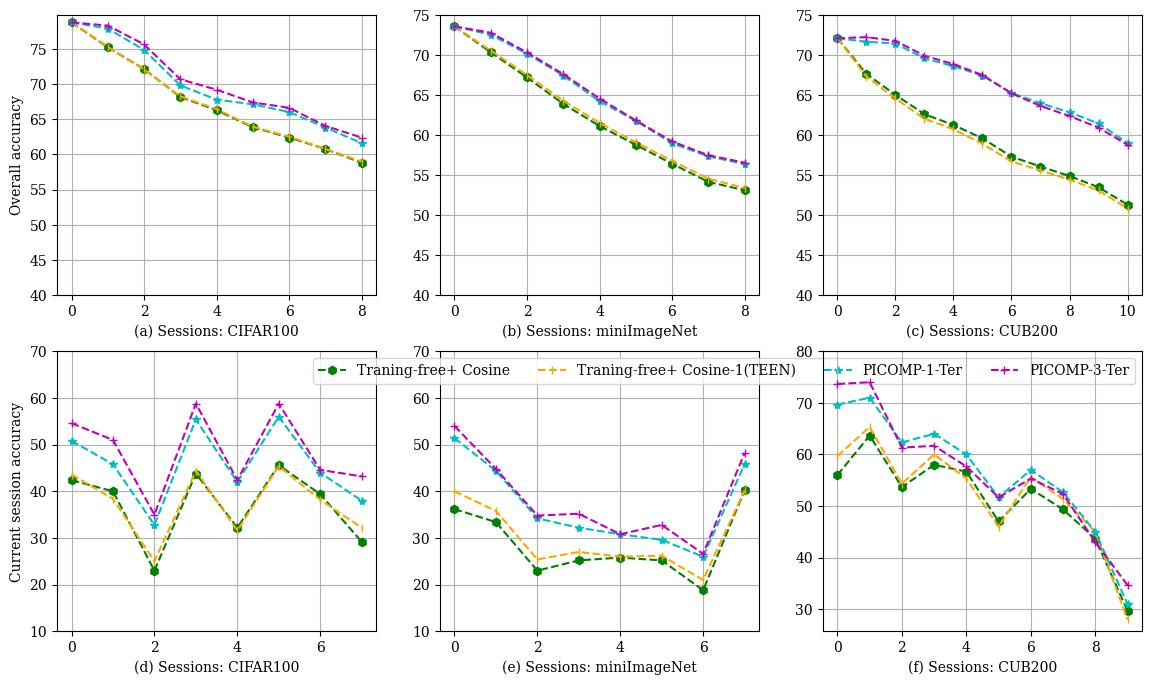

In [89]:
selected_cifarItr = [cifarItr1[i] for i in [2,6,4,0,8]]
selected_cifarItr0 = [cifarItr1[i] for i in [3,7,5,1,9]]
selected_miniItr = [miniItr1[i] for i in [2,6,4,0,8]]
selected_miniItr0 = [miniItr1[i] for i in [3,7,5,1,9]]
selected_cubItr = [cubItr1[i] for i in [2,6,4,0,8]]
selected_cubItr0 = [cubItr1[i] for i in [3,7,5,1,9]]


plt.rc('font', family='serif')
plt.figure(figsize=(14,8))
col=['g','orange','gray','c','m']
mark=['h','|','^','*','+']

plt.subplot(2,3,1)
plt.ylabel("Overall accuracy")
Ind=[0,1,3,4]
for i in Ind:
    plt.plot(selected_cifarItr[i],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(a) Sessions: CIFAR100")
plt.grid(True)
plt.yticks(np.arange(40, 80, 5))

plt.subplot(2,3,2)
for i in Ind:
    plt.plot(selected_miniItr[i],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(b) Sessions: miniImageNet")
plt.grid(True)
plt.yticks(np.arange(40, 80, 5))

plt.subplot(2,3,3)
for i in Ind:
    plt.plot(selected_cubItr[i],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(c) Sessions: CUB200")
plt.grid(True)

plt.yticks(np.arange(40, 80, 5))
plt.subplot(2,3,4)
plt.ylabel("Current session accuracy")
for i in Ind:
    plt.plot(selected_cifarItr0[i][1:],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(d) Sessions: CIFAR100")

plt.grid(True)
plt.yticks(np.arange(10, 80, 10))
plt.subplot(2,3,5)
for i in Ind:
    plt.plot(selected_miniItr0[i][1:],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(e) Sessions: miniImageNet")
plt.grid(True)
plt.yticks(np.arange(10, 80, 10))
plt.subplot(2,3,6)
for i in Ind:
    plt.plot(selected_cubItr0[i][1:],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(f) Sessions: CUB200")
plt.grid(True)
plt.yticks(np.arange(30, 90, 10))
legend=plt.legend(["Traning-free+ Cosine","Traning-free+ Cosine-1(TEEN)","PICOMP-1-Ter","PICOMP-3-Ter"],ncols=5,loc='upper right') #"PICOMP-0-Ter",
legend.set_zorder(0)
plt.savefig('Itr_variation.pdf', format='pdf', bbox_inches='tight')
plt.show()

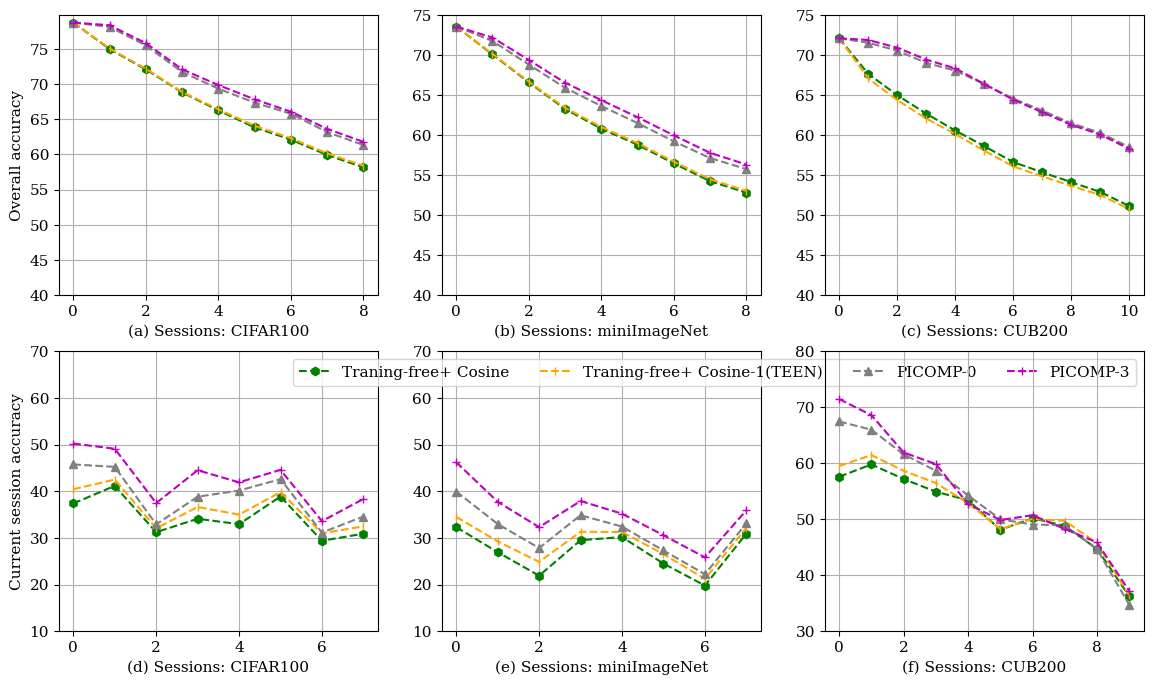

In [175]:
selected_cifarItr = [cifarItr[i] for i in [2,6,4,0,8]]
selected_cifarItr0 = [cifarItr[i] for i in [3,7,5,1,9]]  # 5: 0-itr, 1:1-itr,9:3-itr
selected_miniItr = [miniItr[i] for i in [2,6,4,0,8]]
selected_miniItr0 = [miniItr[i] for i in [3,7,5,1,9]]
selected_cubItr = [cubItr[i] for i in [2,6,4,0,8]]
selected_cubItr0 = [cubItr[i] for i in [3,7,5,1,9]]


plt.rc('font', family='serif')
plt.figure(figsize=(14,8))
col=['g','orange','gray','c','m']
mark=['h','|','^','*','+']

plt.subplot(2,3,1)
plt.ylabel("Overall accuracy")
#Ind=[0,1,3,4]
Ind=[0,1,2,4]
for i in Ind:
    plt.plot(selected_cifarItr[i],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(a) Sessions: CIFAR100")
plt.grid(True)
plt.yticks(np.arange(40, 80, 5))

plt.subplot(2,3,2)
for i in Ind:
    plt.plot(selected_miniItr[i],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(b) Sessions: miniImageNet")
plt.grid(True)
plt.yticks(np.arange(40, 80, 5))

plt.subplot(2,3,3)
for i in Ind:
    plt.plot(selected_cubItr[i],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(c) Sessions: CUB200")
plt.grid(True)
plt.yticks(np.arange(40, 80, 5))
#...........................................................
plt.subplot(2,3,4)
plt.ylabel("Current session accuracy")
for i in Ind:
    plt.plot(selected_cifarItr0[i][1:],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(d) Sessions: CIFAR100")

plt.grid(True)
plt.yticks(np.arange(10, 80, 10))
plt.subplot(2,3,5)
for i in Ind:
    plt.plot(selected_miniItr0[i][1:],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(e) Sessions: miniImageNet")
plt.grid(True)
plt.yticks(np.arange(10, 80, 10))
plt.subplot(2,3,6)
for i in Ind:
    plt.plot(selected_cubItr0[i][1:],marker=mark[i],linestyle='--',color=col[i])
plt.xlabel("(f) Sessions: CUB200")
plt.grid(True)
plt.yticks(np.arange(30, 90, 10))
legend=plt.legend(["Traning-free+ Cosine","Traning-free+ Cosine-1(TEEN)","PICOMP-0","PICOMP-3"],ncols=5,loc='upper right') #"PICOMP-0-Ter",
legend.set_zorder(0)
plt.savefig('Itr_variation.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Acc deviations

In [ ]:
#Error analysis of 10 iteration
# PICAMP_20_6_cifar_01 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=10, IncSession=8,teen=0,itr=1,alpha=0.6)
# print(PICAMP_20_6_cifar_01[1])
#
# PICAMP_5_6_miniImageNet_01 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=10, IncSession=8,teen=0,itr=1,alpha=0.6)
# print(PICAMP_5_6_miniImageNet_01[1])
# PICAMP_5_6_cub_01 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=10, IncSession=10,teen=0,itr=1,alpha=0.6)
# print(PICAMP_5_6_cub_01[1])
a =[0.6247, 0.6152, 0.6251, 0.6108, 0.6208, 0.6246, 0.6152, 0.6234, 0.6269, 0.6142]
b = [0.5659, 0.5654, 0.5587, 0.5593, 0.5617, 0.547, 0.5585, 0.5639, 0.5599, 0.5623]
c = [0.592, 0.583, 0.589, 0.59166664, 0.58166665, 0.58633333, 0.58783334, 0.5901667, 0.5905, 0.5955]

print(np.mean(a),np.mean(b),np.mean(c))
print(np.std(a),np.std(b),np.std(c))

0.62009 0.5602599999999999 0.5887666659999999
0.005416170233661432 0.005100235288690105 0.0039959724334765094


In [177]:
cifar13d= np.mean(cifarItr[9]-cifarItr[5])  #3-iteration- 0-iteration
min13d= np.mean(miniItr[9]-miniItr[5])
cub13d= np.mean(cubItr[9]-cubItr[5])

# cifar13d= np.mean(cifarItr1[9]-cifarItr1[1])
# min13d= np.mean(miniItr1[9]-miniItr1[1])
# cub13d= np.mean(cubItr1[9]-cubItr1[1])

print(np.round([cifar13d,min13d,cub13d],2))


[3.17 3.44 1.01]


## Varying shots

In [128]:
# print(repr(np.round(PICAMP_1_6_cifar_01,2)))
# #print(repr(np.round(PICAMP_5_6_cifar_10,2)))
# print(repr(np.round(PICAMP_10_6_cifar_01,2)))
# print(repr(np.round(PICAMP_20_6_cifar_03,2)))

# print(repr(np.round(PICAMP_1_6_miniImageNet_01,2)))
# print(repr(np.round(PICAMP_10_6_miniImageNet_01,2)))
# print(repr(np.round(PICAMP_20_6_miniImageNet_03,2)))

# print(repr(np.round(PICAMP_1_6_cub_01,2)))
# print(repr(np.round(PICAMP_10_6_cub_10,2)))
# print(repr(np.round(PICAMP_20_6_cub_01,2)))
var_shotsCifar=np.array([[78.77, 75.89, 70.84, 65.83, 62.28, 58.68, 55.9 , 53.84, 51.83],
       [78.77, 17.  ,  7.2 ,  6.8 ,  5.8 ,  4.6 ,  4.  , 18.6 ,  9.8 ],
       [78.77, 80.8 , 80.57, 79.62, 79.73, 79.48, 79.7 , 79.6 , 79.7 ],
       [78.77, 74.  , 69.01, 64.59, 60.85, 57.44, 54.41, 52.38, 50.25],
       [78.77, 18.8 ,  4.4 ,  2.6 ,  5.  ,  4.4 ,  3.6 , 16.2 ,  9.8 ],
       [78.77, 78.6 , 78.58, 78.58, 78.57, 78.48, 78.43, 78.42, 78.42],

       [78.77, 79.03, 76.47, 72.19, 70.8 , 68.96, 67.68, 65.67, 63.77],
       [78.77, 64.  , 52.6 , 44.  , 64.8 , 49.4 , 64.  , 52.6 , 49.  ],
       [78.77, 80.28, 79.93, 78.93, 78.55, 78.22, 77.7 , 77.05, 76.7 ],
       [78.77, 75.66, 72.71, 69.4 , 67.74, 65.35, 64.36, 62.67, 60.9 ],
       [78.77, 53.6 , 43.4 , 38.  , 53.8 , 36.  , 56.6 , 43.6 , 36.8 ],
       [78.77, 77.5 , 76.87, 76.22, 75.77, 75.3 , 74.7 , 74.47, 73.95],

       [78.77, 79.03, 76.63, 71.81, 70.41, 68.58, 68.16, 65.48, 63.41],
       [78.77, 71.2 , 59.  , 46.  , 68.  , 53.  , 65.6 , 58.  , 57.2 ],
       [78.77, 79.68, 79.17, 77.9 , 77.22, 76.8 , 77.32, 76.38, 75.37],
       [78.77, 76.48, 74.  , 70.48, 69.07, 66.94, 66.02, 64.69, 62.91],
       [78.77, 62.2 , 50.6 , 38.8 , 58.6 , 46.2 , 60.8 , 51.2 , 43.6 ],
       [78.77, 77.67, 77.08, 76.38, 75.78, 74.85, 74.1 , 73.72, 73.05]])

 var_shotsMin=np.array([[73.62, 69.55, 64.89, 60.49, 57.39, 54.31, 51.34, 48.63, 46.86],
       [73.62, 10.8 ,  5.  ,  4.4 , 11.4 ,  1.2 ,  3.8 ,  2.6 , 12.2 ],
       [73.62, 74.45, 74.3 , 73.9 , 73.88, 74.1 , 73.95, 73.7 , 73.83],
       [73.62, 68.4 , 63.77, 59.6 , 56.12, 52.89, 50.08, 47.58, 45.71],
       [73.62,  6.2 ,  5.6 ,  3.  ,  5.4 ,  1.6 ,  2.2 ,  2.6 , 10.4 ],
       [73.62, 73.58, 73.42, 73.27, 73.18, 73.15, 73.15, 73.15, 73.13],

       [73.62, 72.92, 70.2 , 68.13, 65.75, 63.52, 60.84, 59.31, 58.41],
       [73.62, 58.2 , 44.6 , 41.6 , 37.2 , 42.  , 40.6 , 33.6 , 49.8 ],
       [73.62, 74.15, 73.85, 73.7 , 73.93, 73.5 , 72.95, 73.15, 72.88],
       [73.62, 71.29, 68.19, 65.24, 62.46, 60.79, 58.42, 56.47, 55.23],
       [73.62, 47.8 , 37.8 , 36.  , 30.  , 38.4 , 33.2 , 28.2 , 41.4 ],
       [73.62, 73.25, 72.55, 71.63, 71.15, 70.85, 70.08, 69.67, 69.23],

       [73.62, 73.2 , 69.99, 68.53, 66.1 , 63.16, 58.52, 57.59, 58.15],
       [73.62, 60.6 , 47.8 , 46.8 , 46.4 , 42.8 , 44.6 , 37.6 , 54.8 ],
       [73.62, 74.25, 73.48, 73.53, 73.37, 71.98, 69.68, 70.22, 71.93],
       [73.62, 71.29, 68.6 , 66.08, 63.8 , 62.27, 60.14, 57.97, 56.92],
       [73.62, 50.6 , 49.8 , 44.2 , 39.6 , 42.6 , 37.4 , 29.  , 44.  ],
       [73.62, 73.02, 71.78, 70.75, 70.23, 69.9 , 69.25, 68.6 , 68.22]])

var_shotsCUB =np.array([[72.13, 68.21, 64.42, 60.36, 58.17, 55.2 , 51.73, 49.75, 47.69, 45.88, 43.77],
       [72.13, 28.  , 28.67, 17.67, 32.33, 11.67, 12.  , 19.  , 18.67, 10.  ,  8.33],
       [72.13, 72.23, 71.77, 71.4 , 71.53, 71.73, 71.53, 71.47, 71.13, 71.2 , 71.27],
       [72.13, 66.48, 61.83, 57.72, 54.81, 51.44, 48.79, 46.71, 44.52, 42.44, 40.27],
       [72.13, 11.67, 16.33,  9.67, 24.  ,  8.  , 10.  , 16.  , 10.33, 9.  ,  5.33],

       [72.13, 71.97, 71.4 , 71.27, 70.6 , 70.27, 70.17, 70.07, 69.83, 69.67, 69.17],
       [72.13, 72.82, 72.28, 70.95, 70.64, 69.8 , 67.92, 66.86, 65.33, 63.95, 61.77],
       [72.13, 79.33, 75.33, 68.  , 70.33, 62.67, 60.33, 56.33, 56.33,46.  , 42.67],
       [72.13, 72.17, 71.77, 71.67, 71.7 , 72.  , 71.37, 71.33, 71.2 ,71.1 , 71.23],
       [72.13, 67.82, 65.17, 63.03, 61.79, 60.6 , 58.98, 57.9 , 56.83, 55.51, 53.35],
       [72.13, 68.67, 71.33, 65.  , 69.  , 61.  , 57.67, 57.  , 58.  , 46.33, 43.33],
       [72.13, 67.73, 64.5 , 62.6 , 60.67, 59.43, 58.03, 56.97, 56.03, 55.3 , 54.33],

        [72.13, 72.7 , 72.83, 71.82, 71.83, 70.29, 68.98, 68.  , 66.8 , 65.54, 63.85],
       [72.13, 77.67, 80.  , 69.67, 75.  , 66.  , 63.33, 66.33, 59.67,  55.67, 55.  ],
       [72.13, 72.2 , 72.07, 72.  , 72.23, 72.03, 71.8 , 71.6 , 71.5 ,  71.53, 71.23],
       [72.13, 67.06, 64.67, 62.64, 61.64, 60.56, 59.08, 58.2 , 57.19,  56.25, 54.85],
       [72.13, 72.67, 76.67, 69.33, 72.  , 65.33, 61.67, 64.  , 61.67,  52.67, 53.33],
       [72.13, 66.5 , 63.03, 60.87, 59.  , 57.77, 56.13, 55.03, 53.8 ,  53.27, 52.4 ]])


IndentationError: unexpected indent (1946971933.py, line 34)

In [135]:

# varying shots

# PICAMP_1_6_cifar_01 = Incremental_train(dbName='cifar100', train_way=5, shot=1,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
# PICAMP_10_6_cifar_01 = Incremental_train(dbName='cifar100', train_way=5, shot=10,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
# PICAMP_20_6_cifar_01 = Incremental_train(dbName='cifar100', train_way=5, shot=20,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
# print(repr(np.round(PICAMP_1_6_cifar_01,2)))
# print(repr(np.round(PICAMP_10_6_cifar_01,2)))
# print(repr(np.round(PICAMP_20_6_cifar_01,2)))

# PICAMP_1_6_miniImageNet_01 = Incremental_train(dbName='miniImageNet', train_way=5, shot=1,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
# PICAMP_10_6_miniImageNet_01 = Incremental_train(dbName='miniImageNet', train_way=5, shot=10,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
PICAMP_20_6_miniImageNet_01 = Incremental_train(dbName='miniImageNet', train_way=5, shot=20,num_batch=10, iteration=1, IncSession=8,teen=0,itr=1,alpha=0.6)
# print(repr(np.round(PICAMP_1_6_miniImageNet_01,2)))
# print(repr(np.round(PICAMP_10_6_miniImageNet_01,2)))
print(repr(np.round(PICAMP_20_6_miniImageNet_01,2)))

# PICAMP_1_6_cub_01 = Incremental_train(dbName='cub200', train_way=10, shot=1,num_batch=10, iteration=1, IncSession=10,teen=0,itr=1,alpha=0.6)
# PICAMP_10_6_cub_01 = Incremental_train(dbName='cub200', train_way=10, shot=10,num_batch=10, iteration=1, IncSession=10,teen=0,itr=1,alpha=0.6)
# PICAMP_20_6_cub_03 = Incremental_train(dbName='cub200', train_way=10, shot=20,num_batch=10, iteration=1, IncSession=10,teen=0,itr=1,alpha=0.6)

# print(repr(np.round(PICAMP_1_6_cub_01,2)))
# print(repr(np.round(PICAMP_10_6_cub_01,2)))
# print(repr(np.round(PICAMP_20_6_cub_01,2)))

var_shotsCifar=np.array([[78.73, 76.15, 70.89, 65.61, 62.19, 58.93, 55.88, 53.81, 51.66],#cifar ternary eval
       [78.73, 73.91, 68.89, 64.47, 60.71, 57.29, 54.3 , 52.39, 50.3 ],

       [78.73, 78.29, 75.7 , 72.05, 69.8 , 67.84, 66.15, 63.66, 61.9 ],
       [78.73, 74.98, 72.08, 68.82, 66.26, 63.84, 62.11, 59.93, 58.17],

       [78.73, 79.2 , 76.39, 72.53, 71.17, 69.27, 68.54, 66.58, 64.76],
       [78.73, 75.66, 72.76, 69.39, 67.85, 65.53, 64.49, 62.87, 61.14],

       [78.73, 79.48, 77.5 , 73.43, 72.24, 70.55, 69.74, 68.11, 65.94],
       [78.73, 76.46, 73.99, 70.44, 69.05, 66.98, 66.  , 64.65, 62.81]])

var_shotsCifar1=np.array([[78.77, 75.89, 70.84, 65.83, 62.28, 58.68, 55.9 , 53.84, 51.83], #1 yt
       [78.77, 17.  ,  7.2 ,  6.8 ,  5.8 ,  4.6 ,  4.  , 18.6 ,  9.8 ],

       [78.77, 77.88, 74.86, 69.81, 67.8 , 67.12, 66.04, 63.83, 61.61], #5
       [78.77, 50.8 , 45.8 , 32.8 , 55.4 , 42.  , 56.  , 44.  , 38.  ],

       [78.77, 79.03, 76.47, 72.19, 70.8 , 68.96, 67.68, 65.67, 63.77], #10
       [78.77, 64.  , 52.6 , 44.  , 64.8 , 49.4 , 64.  , 52.6 , 49.  ],

       [78.77, 79.03, 76.63, 71.81, 70.41, 68.58, 68.16, 65.48, 63.41], #20
       [78.77, 71.2 , 59.  , 46.  , 68.  , 53.  , 65.6 , 58.  , 57.2 ]])


var_shotsMin = np.array([[73.6 , 69.6 , 64.8 , 60.52, 57.38, 54.22, 51.21, 48.63, 46.69], #min ternary
       [73.6 , 68.45, 63.77, 59.63, 56.16, 52.92, 50.12, 47.61, 45.68],

       [73.6 , 72.  , 69.19, 66.37, 64.05, 61.96, 59.78, 57.62, 56.12],
       [73.6 , 70.11, 66.63, 63.29, 60.83, 58.82, 56.49, 54.26, 52.84],

       [73.6 , 73.15, 70.87, 68.47, 65.76, 63.95, 61.59, 60.03, 59.01],
       [73.6 , 71.2 , 68.14, 65.23, 62.41, 60.66, 58.33, 56.37, 55.2 ],

       [73.6 , 73.43, 71.09, 69.32, 67.09, 64.88, 62.29, 60.81, 60.34],
       [73.6 , 71.28, 68.5 , 66.07, 63.76, 62.27, 60.14, 58.  , 56.94]])

var_shotsMin1=np.array([[73.62, 69.55, 64.89, 60.49, 57.39, 54.31, 51.34, 48.63, 46.86],  # 1 yt
       [73.62, 10.8 ,  5.  ,  4.4 , 11.4 ,  1.2 ,  3.8 ,  2.6 , 12.2 ],

        [73.62, 72.58, 70.2 , 67.47, 64.26, 61.82, 59.01, 57.37, 56.4 ], #5
       [73.62, 51.4 , 44.4 , 34.2 , 32.2 , 30.8 , 29.6 , 26.  , 45.8 ],

       [73.62, 72.92, 70.2 , 68.13, 65.75, 63.52, 60.84, 59.31, 58.41], #10
       [73.62, 58.2 , 44.6 , 41.6 , 37.2 , 42.  , 40.6 , 33.6 , 49.8 ],

       [73.62, 73.2 , 69.99, 68.53, 66.1 , 63.16, 58.52, 57.59, 58.15], #20
       [73.62, 60.6 , 47.8 , 46.8 , 46.4 , 42.8 , 44.6 , 37.6 , 54.8 ]])


var_shotsCUB = np.array([[72.13, 68.18, 64.31, 60.23, 58.19, 55.29, 52.4 , 50.25, 48.13, 46.14, 43.92], #cub200 ternary
        [72.13, 66.64, 62.17, 58.08, 55.05, 51.69, 48.92, 46.8 , 44.7 , 42.53, 40.4 ],

        [72.13, 71.7 , 70.74, 69.38, 68.38, 66.62, 64.75, 63.2 , 61.59, 60.34, 58.55],
        [72.13, 67.69, 65.02, 62.71, 60.6 , 58.65, 56.65, 55.38, 54.14, 52.92, 51.16],

        [72.13, 72.73, 72.19, 70.85, 70.52, 69.96, 68.12, 67.02, 65.74, 64.  , 61.7 ],
        [72.13, 67.73, 65.22, 62.97, 61.76, 60.56, 59.  , 57.88, 56.81, 55.47, 53.28],

        [72.13, 72.73, 72.20, 71.85, 71.48, 70.86, 70.12, 69.02, 67.14, 65.20  , 63.6 ]])

var_shotsCUB1 =np.array([[72.13, 68.21, 64.42, 60.36, 58.17, 55.2 , 51.73, 49.75, 47.69, 45.88, 43.77], #1 yt
       [72.13, 28.  , 28.67, 17.67, 32.33, 11.67, 12.  , 19.  , 18.67, 10.  ,  8.33],

       [72.13, 71.7 , 71.47, 69.62, 68.64, 67.47, 65.27, 64.02, 62.87,61.49, 59.05], #5
       [72.13, 69.67, 71.  , 62.33, 64.  , 60.  , 51.67, 57.  , 52.67, 45.  , 31.  ],

       [72.13, 72.82, 72.28, 70.95, 70.64, 69.8 , 67.92, 66.86, 65.33, 63.95, 61.77], #10
       [72.13, 79.33, 75.33, 68.  , 70.33, 62.67, 60.33, 56.33, 56.33,46.  , 42.67],

       [72.13, 72.7 , 72.83, 71.82, 71.83, 70.29, 68.98, 68.  , 66.8 , 65.54, 63.85], #20
       [72.13, 77.67, 80.  , 69.67, 75.  , 66.  , 63.33, 66.33, 59.67,  55.67, 55.  ]])



Dataset size: (100, 600, 84, 84, 3)
Base Acc: 0.73616666
0 tf.Tensor(0.8498329, shape=(), dtype=float32) tf.Tensor(-0.005800605, shape=(), dtype=float32)
session:.................................................................... 0
10/10 [==============================] - 5s 408ms/step - loss: 0.5120 - accuracy: 1.0000
PICOMP Acc: 73.23 60.2 74.32
Standard Acc: 71.29 50.6 73.02
0 tf.Tensor(0.95845056, shape=(), dtype=float32) tf.Tensor(0.0006367564, shape=(), dtype=float32)
session:.................................................................... 1
10/10 [==============================] - 5s 413ms/step - loss: 0.6991 - accuracy: 1.0000
PICOMP Acc: 69.81 47.8 73.23
Standard Acc: 68.5 48.4 71.78
0 tf.Tensor(0.9712951, shape=(), dtype=float32) tf.Tensor(0.0024731755, shape=(), dtype=float32)
session:.................................................................... 2
10/10 [==============================] - 5s 407ms/step - loss: 0.5899 - accuracy: 1.0000
PICOMP Acc: 68.39 46.0 73.47

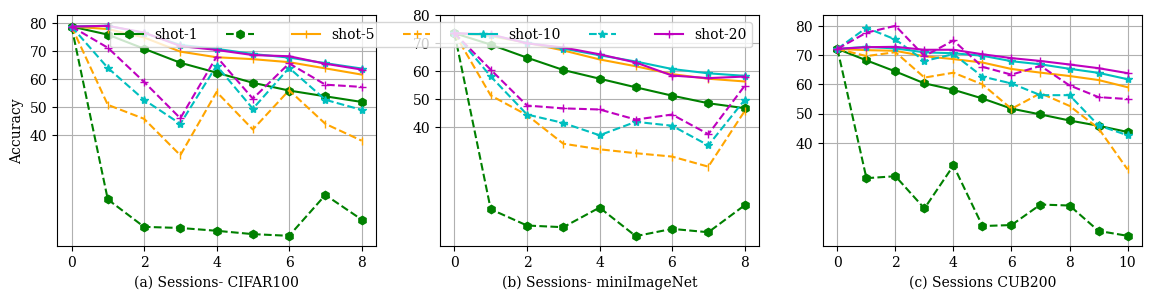

In [137]:
#var_shotsCifar,var_shotsMin,var_shotsCUB
plt.figure(figsize=(14,3))
plt.rc('font', family='serif', weight='normal') #, size=9
col=['g','orange','c','m']
mark=['h','|','*','+']
style=['-','--']
Ind=[0,2,4,6]
plt.subplot(1,3,1)
for i in Ind:
    plt.plot(var_shotsCifar1[i],marker=mark[i//2],linestyle=style[i%2],color=col[i//2])
    plt.plot(var_shotsCifar1[i+1],marker=mark[i//2],linestyle=style[1],color=col[i//2])
plt.ylabel("Accuracy")
plt.grid(True)
plt.yticks(np.arange(40, 90, 10))
plt.xlabel("(a) Sessions- CIFAR100")

plt.subplot(1,3,2)
for i in Ind:
    plt.plot(var_shotsMin1[i],marker=mark[i//2],linestyle= style[i%2],color=col[i//2])
    plt.plot(var_shotsMin1[i+1],marker=mark[i//2],linestyle= style[1],color=col[i//2])
plt.grid(True)
plt.yticks(np.arange(40, 90, 10))
plt.xlabel("(b) Sessions- miniImageNet")
plt.legend(["shot-1","","shot-5","","shot-10","","shot-20"], ncols=8,loc='upper right')
plt.subplot(1,3,3)
for i in Ind:
    plt.plot(var_shotsCUB1[i],marker=mark[i//2],linestyle=style[i%2],color=col[i//2])
    plt.plot(var_shotsCUB1[i+1],marker=mark[i//2],linestyle=style[1],color=col[i//2])
plt.grid(True)
plt.yticks(np.arange(40, 90, 10))
plt.xlabel("(c) Sessions CUB200")

plt.savefig('varyingShot1.pdf', format='pdf', bbox_inches='tight')
plt.show()

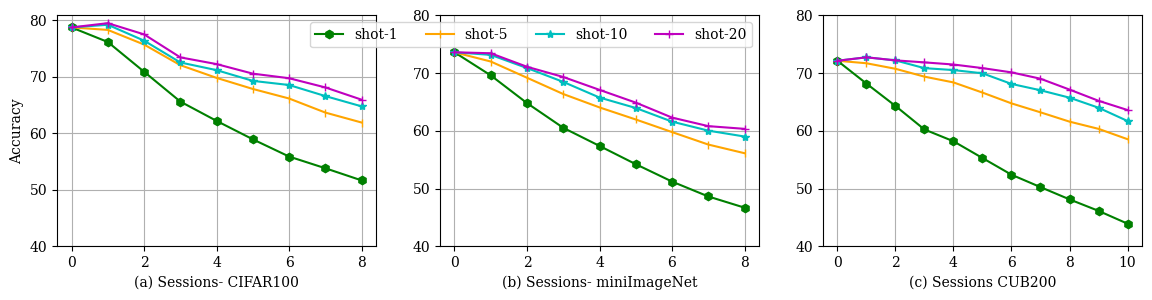

In [ ]:
#var_shotsCifar,var_shotsMin,var_shotsCUB
plt.figure(figsize=(14,3))
plt.rc('font', family='serif', weight='normal') #, size=9
col=['g','orange','c','m']
mark=['h','|','*','+']
style=['-','--']
Ind=[0,2,4,6]
plt.subplot(1,3,1)
for i in Ind:
    plt.plot(var_shotsCifar[i],marker=mark[i//2],linestyle=style[i%2],color=col[i//2])
plt.ylabel("Accuracy")
plt.grid(True)
plt.yticks(np.arange(40, 90, 10))
plt.xlabel("(a) Sessions- CIFAR100")

plt.subplot(1,3,2)
for i in Ind:
    plt.plot(var_shotsMin[i],marker=mark[i//2],linestyle= style[i%2],color=col[i//2])
plt.grid(True)
plt.yticks(np.arange(40, 90, 10))
plt.xlabel("(b) Sessions- miniImageNet")
plt.legend(["shot-1","shot-5","shot-10","shot-20"], ncols=8,loc='upper right')
plt.subplot(1,3,3)
for i in Ind:
    plt.plot(var_shotsCUB[i],marker=mark[i//2],linestyle=style[i%2],color=col[i//2])
plt.grid(True)
plt.yticks(np.arange(40, 90, 10))
plt.xlabel("(c) Sessions CUB200")

plt.savefig('varyingShot1.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# print(repr(np.round(PICAMP_5_4_cub200_11[0],2)))
# print(repr(np.round(PICAMP_5_6_cub200_11[0],2)))
print(repr(np.round(PICAMP_5_9_cub200_11[0],2)))
array([[72.07, 68.85, 65.5 , 62.21, 59.36, 56.47, 54.06, 51.94, 49.78, 47.86, 45.33], #0.4
       [72.07, 37.  , 36.33, 31.33, 27.  , 23.67, 25.33, 25.67, 22.33, 17.67,  7.  ],
       [72.07, 72.03, 71.7 , 71.67, 71.73, 71.9 , 71.93, 71.7 , 71.7 , 71.6 , 71.67],
       [72.07, 67.18, 64.5 , 62.  , 60.55, 58.73, 56.44, 55.29, 54.22, 53.02, 50.77],
       [72.07, 58.67, 65.  , 54.  , 58.67, 56.33, 45.  , 54.  , 52.  , 45.  , 28.33],
       [72.07, 68.03, 65.33, 63.67, 62.5 , 61.23, 59.97, 59.13, 58.27, 57.47, 56.73]])

array([[72.07, 70.58, 68.92, 66.  , 64.6 , 62.64, 60.35, 58.78, 56.91, 55.05, 52.73], #0.6
       [72.07, 57.  , 58.33, 47.  , 50.67, 43.  , 36.  , 42.  , 38.  , 30.67, 18.33],
       [72.07, 71.93, 71.63, 71.63, 71.8 , 72.  , 71.87, 71.73, 71.5 , 71.67, 71.73],
       [72.07, 67.24, 64.39, 61.87, 60.48, 58.8 , 56.42, 55.35, 54.37, 53.04, 50.75],
       [72.07, 58.67, 64.67, 54.33, 58.33, 57.67, 45.67, 56.  , 52.67, 43.67, 29.33],
       [72.07, 68.1 , 65.2 , 63.5 , 62.33, 61.13, 59.83, 58.87, 58.07, 57.17, 56.43]])

array([[72.07, 71.97, 71.22, 69.59, 68.67, 67.24, 65.31, 64.25, 62.76, 61.58, 59.25], #0.9
       [72.07, 71.  , 72.  , 60.33, 64.  , 58.  , 50.67, 55.67, 52.  , 45.  , 30.33],
       [72.07, 72.07, 71.57, 71.67, 71.7 , 71.87, 71.87, 71.8 , 71.47, 71.63, 71.83],
       [72.07, 67.27, 64.58, 62.28, 60.86, 58.96, 56.58, 55.39, 54.2 , 52.93, 50.65],
       [72.07, 59.33, 65.33, 55.  , 59.67, 56.67, 45.33, 54.33, 50.33, 45.67, 29.67],
       [72.07, 68.07, 65.3 , 63.7 , 62.4 , 61.  , 59.73, 58.8 , 57.87, 56.97, 56.23]])




array([[72.07, 64.18, 62.78, 60.41, 59.6 , 58.16, 56.17, 55.16, 53.33,
        52.47, 50.23],
       [72.07, 70.33, 71.33, 58.33, 62.67, 57.33, 47.33, 53.  , 49.  ,
        44.  , 31.33],
       [72.07, 63.57, 61.63, 59.97, 59.5 , 58.77, 57.77, 57.2 , 56.27,
        55.93, 55.4 ],
       [72.07, 67.27, 64.56, 62.05, 60.74, 59.09, 56.77, 55.65, 54.52,
        53.25, 51.02],
       [72.07, 59.67, 64.33, 54.  , 60.  , 57.33, 44.67, 54.  , 52.33,
        45.  , 30.  ],
       [72.07, 68.03, 65.3 , 63.63, 62.47, 61.33, 60.07, 59.13, 58.27,
        57.33, 56.63]])


NameError: name 'array' is not defined

## Varying Apha

In [99]:

#Varying Alpha
# PICAMP_5_4_cifar_11 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.4)
# PICAMP_5_6_cifar_11 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.6)
# PICAMP_5_9_cifar_11 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.9)
# print(repr(np.round(PICAMP_5_4_cifar_11,2)))
# print(repr(np.round(PICAMP_5_6_cifar_11,2)))
# print(repr(np.round(PICAMP_5_9_cifar_11,2)))
# PICAMP_5_4_miniImageNet_11 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.4)
# PICAMP_5_6_miniImageNet_11 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.6)
# PICAMP_5_9_miniImageNet_11 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.9)
# print(repr(np.round(PICAMP_5_4_miniImageNet_11,2)))
# print(repr(np.round(PICAMP_5_6_miniImageNet_11,2)))
# print(repr(np.round(PICAMP_5_9_miniImageNet_11,2)))
# PICAMP_5_4_cub200_11 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=1,itr=1,alpha=0.4)
# PICAMP_5_6_cub200_11 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=1,itr=1,alpha=0.6)
# PICAMP_5_9_cub200_11 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=1,itr=1,alpha=0.9)
# print(repr(np.round(PICAMP_5_4_cub200_11,2)))
# print(repr(np.round(PICAMP_5_6_cub200_11,2)))
# print(repr(np.round(PICAMP_5_9_cub200_11,2)))

array([[78.77, 74.95, 70.09, 64.64, 61.44, 58.69, 56.42, 53.96, 51.29],
       [78.77, 11.8 , 13.8 ,  6.4 , 18.2 , 13.2 , 21.  , 17.4 , 11.2 ],
       [78.77, 80.22, 79.82, 78.52, 78.27, 78.28, 78.12, 77.73, 76.75],
       [78.77, 75.35, 72.17, 68.25, 66.41, 64.  , 62.59, 60.84, 58.98],
       [78.77, 44.2 , 38.  , 24.4 , 45.  , 32.6 , 46.2 , 38.4 , 30.6 ],
       [78.77, 77.95, 77.52, 77.1 , 76.78, 76.28, 75.73, 75.53, 75.23]])
array([[78.77, 76.51, 72.79, 67.36, 64.94, 62.2 , 60.73, 58.76, 56.44],
       [78.77, 32.6 , 29.6 , 19.4 , 39.8 , 23.  , 40.6 , 33.4 , 20.8 ],
       [78.77, 80.17, 80.03, 78.38, 77.92, 77.75, 77.58, 77.47, 76.85],
       [78.77, 75.35, 72.31, 68.37, 66.52, 64.14, 62.84, 61.07, 59.24],
       [78.77, 43.8 , 40.2 , 23.8 , 44.4 , 32.8 , 48.2 , 39.6 , 31.8 ],
       [78.77, 77.98, 77.53, 77.17, 76.87, 76.42, 75.87, 75.63, 75.3 ]])
array([[78.77, 77.88, 74.8 , 70.27, 68.28, 66.59, 65.56, 63.61, 61.16],
       [78.77, 51.8 , 43.6 , 31.4 , 54.6 , 38.2 , 53.8 , 43.  

In [102]:
cifarAlpha=np.array([[78.77, 74.95, 70.09, 64.64, 61.44, 58.69, 56.42, 53.96, 51.29], #aplha =0.4 #yPred = yc+(yt-yc)*alpha
       [78.77, 11.8 , 13.8 ,  6.4 , 18.2 , 13.2 , 21.  , 17.4 , 11.2 ],
       [78.77, 80.22, 79.82, 78.52, 78.27, 78.28, 78.12, 77.73, 76.75],
       [78.77, 75.35, 72.17, 68.25, 66.41, 64.  , 62.59, 60.84, 58.98],
       [78.77, 44.2 , 38.  , 24.4 , 45.  , 32.6 , 46.2 , 38.4 , 30.6 ],
       [78.77, 77.95, 77.52, 77.1 , 76.78, 76.28, 75.73, 75.53, 75.23],

       [78.77, 76.51, 72.79, 67.36, 64.94, 62.2 , 60.73, 58.76, 56.44], #aplha =0.6
       [78.77, 32.6 , 29.6 , 19.4 , 39.8 , 23.  , 40.6 , 33.4 , 20.8 ],
       [78.77, 80.17, 80.03, 78.38, 77.92, 77.75, 77.58, 77.47, 76.85],
       [78.77, 75.35, 72.31, 68.37, 66.52, 64.14, 62.84, 61.07, 59.24],
       [78.77, 43.8 , 40.2 , 23.8 , 44.4 , 32.8 , 48.2 , 39.6 , 31.8 ],
       [78.77, 77.98, 77.53, 77.17, 76.87, 76.42, 75.87, 75.63, 75.3 ],

       [78.77, 77.88, 74.8 , 70.27, 68.28, 66.59, 65.56, 63.61, 61.16], #aplha =0.9
       [78.77, 51.8 , 43.6 , 31.4 , 54.6 , 38.2 , 53.8 , 43.  , 34.  ],
       [78.77, 80.05, 79.68, 78.82, 78.1 , 78.2 , 78.27, 77.82, 76.87],
       [78.77, 75.35, 72.23, 68.2 , 66.3 , 63.85, 62.52, 60.84, 58.96],
       [78.77, 44.  , 39.  , 23.6 , 43.6 , 32.2 , 47.  , 39.  , 30.8 ],
       [78.77, 77.97, 77.52, 77.03, 76.75, 76.22, 75.72, 75.52, 75.15]])


miniAlpha=np.array([[73.62, 70.28, 65.74, 61.72, 58.01, 54.98, 51.66, 49.28, 47.66],
       [73.62, 21.4 ,  9.8 ,  5.6 , 10.8 ,  8.6 ,  6.4 ,  6.  , 12.4 ],
       [73.62, 74.35, 74.3 , 74.27, 73.88, 73.9 , 73.13, 73.33, 73.63],
       [73.62, 70.62, 67.53, 64.33, 61.65, 59.27, 56.88, 54.68, 53.53],
       [73.62, 40.4 , 36.8 , 26.  , 27.6 , 27.4 , 26.4 , 21.2 , 41.  ],
       [73.62, 73.13, 72.48, 72.02, 71.65, 71.37, 70.93, 70.57, 70.1 ],

       [73.62, 71.34, 67.74, 64.47, 61.2 , 58.08, 55.37, 53.07, 51.97],
       [73.62, 36.4 , 25.8 , 20.  , 23.2 , 19.2 , 17.  , 13.6 , 32.6 ],
       [73.62, 74.25, 74.15, 74.07, 73.88, 73.55, 73.17, 73.25, 73.52],
       [73.62, 70.6 , 67.51, 64.27, 61.44, 59.15, 56.81, 54.61, 53.47],
       [73.62, 40.2 , 36.  , 25.2 , 25.8 , 28.  , 27.2 , 20.4 , 41.  ],
       [73.62, 73.13, 72.55, 72.08, 71.65, 71.37, 70.98, 70.62, 70.15],

       [73.62, 72.29, 70.13, 67.08, 64.14, 61.53, 58.6 , 56.83, 55.89],
       [73.62, 49.2 , 43.  , 32.  , 32.4 , 29.  , 28.4 , 24.2 , 43.2 ],
       [73.62, 74.22, 74.32, 74.12, 73.78, 73.5 , 73.  , 73.15, 73.4 ],
       [73.62, 70.68, 67.57, 64.43, 61.55, 59.18, 56.79, 54.52, 53.45],
       [73.62, 41.4 , 36.  , 26.2 , 25.4 , 26.6 , 27.  , 19.2 , 41.6 ],
       [73.62, 73.12, 72.47, 72.03, 71.62, 71.35, 70.92, 70.55, 70.08]])

cubAlpha=np.array([[72.13, 68.82, 65.75, 62.23, 59.55, 56.71, 53.92, 51.76, 49.39, 47.47, 45.38],
       [72.13, 37.67, 36.67, 31.  , 27.33, 24.67, 24.67, 25.33, 20.67, 17.67,  6.  ],
       [72.13, 71.93, 72.  , 71.7 , 71.87, 72.07, 71.73, 71.47, 71.3 , 71.47, 71.77],
       [72.13, 67.15, 64.31, 62.05, 60.55, 58.64, 56.46, 55.22, 54.17, 52.84, 50.63],
       [72.13, 59.  , 64.  , 55.  , 58.67, 55.67, 46.67, 53.67, 50.  , 44.  , 29.33],
       [72.13, 67.97, 65.17, 63.6 , 62.37, 61.07, 59.8 , 58.83, 58.03, 57.13, 56.47],

       [72.13, 70.64, 69.33, 66.72, 64.9 , 62.76, 60.04, 58.71, 56.8 , 55.18, 52.72],
       [72.13, 57.33, 59.  , 48.33, 49.33, 43.  , 38.33, 42.33, 38.67, 31.67, 18.33],
       [72.13, 71.97, 72.1 , 71.77, 71.83, 72.17, 71.67, 71.7 , 71.5 , 71.73, 71.6 ],
       [72.13, 67.15, 64.28, 61.79, 60.57, 59.  , 56.69, 55.27, 54.24, 52.86, 50.82],
       [72.13, 58.33, 64.67, 54.33, 60.  , 58.  , 46.  , 52.  , 52.67, 43.67, 30.  ],
       [72.13, 68.03, 65.13, 63.27, 62.23, 60.97, 59.77, 58.77, 57.9 , 56.97, 56.43],

       [72.13, 72.  , 71.06, 69.05, 68.26, 66.44, 64.52, 63.29, 62.24, 60.96, 58.67],
       [72.13, 69.33, 70.  , 57.67, 62.33, 58.  , 50.  , 54.67, 52.33, 45.33, 29.67],
       [72.13, 72.27, 71.7 , 71.63, 71.8 , 71.57, 71.7 , 71.47, 71.57, 71.6 , 71.77],
       [72.13, 67.27, 64.36, 62.13, 60.71, 58.93, 56.85, 55.53, 54.56, 53.26, 51.15],
       [72.13, 57.33, 64.67, 56.  , 58.67, 57.33, 46.33, 53.33, 52.67, 45.33, 30.67],
       [72.13, 68.27, 65.33, 63.73, 62.6 , 61.2 , 59.9 , 58.8 , 57.97, 57.17, 56.47]])

In [ ]:
#remove alpha take average....  #yPred = yc+(ys-yc)*alpha
# print(repr(np.round(PICAMP_5_4_cifar_11,2)))
# print(repr(np.round(PICAMP_5_6_cifar_11,2)))
# print(repr(np.round(PICAMP_5_9_cifar_11,2)))
# print(repr(np.round(PICAMP_5_4_miniImageNet_11,2)))
# print(repr(np.round(PICAMP_5_6_miniImageNet_11,2)))
# print(repr(np.round(PICAMP_5_9_miniImageNet_11,2)))
# print(repr(np.round(PICAMP_5_4_cub200_11,2)))
# print(repr(np.round(PICAMP_5_6_cub200_11,2)))
# print(repr(np.round(PICAMP_5_9_cub200_11,2)))
cifarAlpha=np.array([[78.77, 75.34, 70.46, 65.36, 61.99, 59.01, 56.69, 54.19, 51.76],
       [78.77, 11.4 , 11.2 ,  4.2 , 14.4 , 10.4 , 16.6 , 13.  ,  8.  ],
       [78.77, 80.67, 80.45, 79.77, 79.58, 79.67, 79.88, 79.65, 79.33],
       [78.77, 75.26, 72.26, 68.4 , 66.52, 64.05, 62.66, 60.96, 59.1 ],
       [78.77, 43.6 , 40.  , 24.6 , 44.2 , 32.6 , 46.2 , 39.4 , 31.  ],
       [78.77, 77.9 , 77.5 , 77.15, 76.83, 76.28, 75.75, 75.55, 75.2 ],

       [78.77, 76.94, 72.77, 67.91, 65.3 , 62.81, 61.16, 59.17, 57.  ],
       [78.77, 31.  , 26.6 , 14.6 , 34.2 , 20.  , 37.2 , 28.6 , 17.4 ],
       [78.77, 80.77, 80.37, 79.68, 79.35, 79.65, 79.68, 79.68, 79.27],
       [78.77, 75.2 , 72.11, 68.28, 66.36, 63.88, 62.51, 60.69, 58.85],
       [78.77, 42.  , 39.  , 25.2 , 43.8 , 32.2 , 46.4 , 37.8 , 31.6 ],
       [78.77, 77.97, 77.55, 77.13, 76.83, 76.28, 75.75, 75.5 , 75.15],

       [78.77, 78.23, 75.29, 70.67, 68.9 , 67.01, 65.86, 63.84, 61.81],
       [78.77, 48.2 , 42.  , 27.  , 49.  , 35.8 , 50.6 , 38.4 , 29.6 ],
       [78.77, 80.73, 80.6 , 79.65, 79.57, 79.68, 79.62, 79.63, 79.3 ],
       [78.77, 75.25, 72.17, 68.29, 66.59, 64.07, 62.66, 60.97, 59.13],
       [78.77, 42.6 , 39.6 , 24.4 , 46.  , 31.8 , 46.  , 37.4 , 30.4 ],
       [78.77, 77.97, 77.52, 77.17, 76.88, 76.32, 75.75, 75.57, 75.22]])

miniAlpha=np.array([[73.62, 70.23, 65.79, 61.76, 58.09, 55.08, 52.06, 49.55, 47.43],
       [73.62, 20.4 , 10.2 ,  4.8 ,  9.6 ,  8.  ,  5.2 ,  6.6 , 11.  ],
       [73.62, 74.38, 74.42, 74.35, 74.05, 74.07, 74.1 , 74.07, 73.9 ],
       [73.62, 70.58, 67.6 , 64.48, 61.69, 59.39, 57.07, 54.8 , 53.65],
       [73.62, 40.6 , 36.2 , 27.  , 26.6 , 28.  , 28.  , 20.4 , 40.4 ],
       [73.62, 73.08, 72.5 , 72.05, 71.62, 71.35, 70.93, 70.57, 70.1 ],

       [73.62, 71.42, 67.76, 64.52, 61.01, 58.21, 55.31, 52.93, 51.6 ],
       [73.62, 35.  , 23.8 , 19.4 , 21.  , 17.  , 13.4 , 13.2 , 30.4 ],
       [73.62, 74.45, 74.38, 74.48, 74.05, 74.08, 74.15, 74.1 , 74.05],
       [73.62, 70.52, 67.39, 64.16, 61.38, 59.09, 56.71, 54.49, 53.32],
       [73.62, 39.8 , 35.6 , 24.8 , 26.4 , 27.6 , 25.6 , 20.8 , 40.2 ],
       [73.62, 73.08, 72.43, 71.98, 71.55, 71.3 , 70.93, 70.55, 70.07],

       [73.62, 72.29, 69.87, 66.8 , 63.91, 61.34, 59.16, 56.78, 55.68],
       [73.62, 47.  , 40.8 , 30.4 , 30.8 , 27.2 , 27.4 , 20.6 , 41.8 ],
       [73.62, 74.4 , 74.48, 74.35, 74.08, 74.  , 74.08, 73.97, 73.73],
       [73.62, 70.57, 67.59, 64.43, 61.62, 59.25, 56.81, 54.65, 53.49],
       [73.62, 40.2 , 38.  , 25.8 , 25.8 , 27.8 , 25.6 , 21.  , 40.6 ],
       [73.62, 73.1 , 72.4 , 72.02, 71.65, 71.35, 70.97, 70.62, 70.15]])


cubAlpha=np.array([[72.07, 68.85, 65.5 , 62.21, 59.36, 56.47, 54.06, 51.94, 49.78, 47.86, 45.33], #0.4
       [72.07, 37.  , 36.33, 31.33, 27.  , 23.67, 25.33, 25.67, 22.33, 17.67,  7.  ],
       [72.07, 72.03, 71.7 , 71.67, 71.73, 71.9 , 71.93, 71.7 , 71.7 , 71.6 , 71.67],
       [72.07, 67.18, 64.5 , 62.  , 60.55, 58.73, 56.44, 55.29, 54.22, 53.02, 50.77],
       [72.07, 58.67, 65.  , 54.  , 58.67, 56.33, 45.  , 54.  , 52.  , 45.  , 28.33],
       [72.07, 68.03, 65.33, 63.67, 62.5 , 61.23, 59.97, 59.13, 58.27, 57.47, 56.73],

       [72.07, 70.58, 68.92, 66.  , 64.6 , 62.64, 60.35, 58.78, 56.91, 55.05, 52.73], #0.6
       [72.07, 57.  , 58.33, 47.  , 50.67, 43.  , 36.  , 42.  , 38.  , 30.67, 18.33],
       [72.07, 71.93, 71.63, 71.63, 71.8 , 72.  , 71.87, 71.73, 71.5 , 71.67, 71.73],
       [72.07, 67.24, 64.39, 61.87, 60.48, 58.8 , 56.42, 55.35, 54.37, 53.04, 50.75],
       [72.07, 58.67, 64.67, 54.33, 58.33, 57.67, 45.67, 56.  , 52.67, 43.67, 29.33],
       [72.07, 68.1 , 65.2 , 63.5 , 62.33, 61.13, 59.83, 58.87, 58.07, 57.17, 56.43],

       [72.07, 71.97, 71.22, 69.59, 68.67, 67.24, 65.31, 64.25, 62.76, 61.58, 59.25], #0.9
       [72.07, 71.  , 72.  , 60.33, 64.  , 58.  , 50.67, 55.67, 52.  , 45.  , 30.33],
       [72.07, 72.07, 71.57, 71.67, 71.7 , 71.87, 71.87, 71.8 , 71.47, 71.63, 71.83],
       [72.07, 67.27, 64.58, 62.28, 60.86, 58.96, 56.58, 55.39, 54.2 , 52.93, 50.65],
       [72.07, 59.33, 65.33, 55.  , 59.67, 56.67, 45.33, 54.33, 50.33, 45.67, 29.67],
       [72.07, 68.07, 65.3 , 63.7 , 62.4 , 61.  , 59.73, 58.8 , 57.87, 56.97, 56.23]])

array([[72.13, 71.88, 71.53, 69.92, 68.81, 67.29, 65.19, 64.06, 62.87, 61.46, 59.08],
       [72.13, 71.  , 71.33, 59.67, 63.33, 59.67, 50.33, 56.67, 54.33, 46.67, 33.67],
       [72.13, 71.77, 71.73, 71.7 , 71.7 , 71.63, 71.63, 71.6 , 71.53, 71.53, 71.53],
       [72.13, 67.36, 64.53, 62.23, 60.81, 58.87, 56.56, 55.2 , 54.13, 52.77, 50.62],
       [72.13, 59.33, 65.  , 55.  , 59.67, 55.  , 45.33, 52.67, 52.  , 44.67, 29.33],
       [72.13, 68.17, 65.33, 63.73, 62.5 , 61.23, 59.9 , 58.87, 58.  , 57.07, 56.43]])

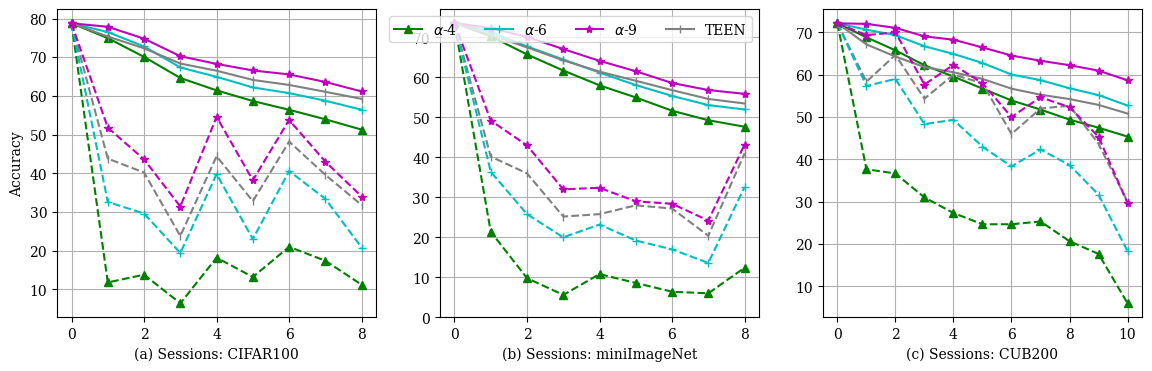

In [103]:

plt.rc('font', family='serif')
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(cifarAlpha[0,:],marker='^',linestyle='-',color='g')
plt.plot(cifarAlpha[6,:],marker='+',linestyle='-',color='c')
plt.plot(cifarAlpha[12,:],marker='*',linestyle='-',color='m')
plt.plot(cifarAlpha[9,:],marker='|',linestyle='-',color='gray')  #TEEN
plt.plot(cifarAlpha[10,:],marker='|',linestyle='--',color='gray')  #TEEN

plt.plot(cifarAlpha[1,:],marker='^',linestyle='--',color='g')
plt.plot(cifarAlpha[7,:],marker='+',linestyle='--',color='c')
plt.plot(cifarAlpha[13,:],marker='*',linestyle='--',color='m')
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlabel("(a) Sessions: CIFAR100")

plt.subplot(1,3,2)
plt.plot(miniAlpha[0,:],marker='^',linestyle='-',color='g')
plt.plot(miniAlpha[6,:],marker='+',linestyle='-',color='c')
plt.plot(miniAlpha[12,:],marker='*',linestyle='-',color='m')
plt.plot(miniAlpha[9,:],marker='|',linestyle='-',color='gray')  #TEEN
plt.plot(miniAlpha[10,:],marker='|',linestyle='--',color='gray')  #TEEN

plt.plot(miniAlpha[1,:],marker='^',linestyle='--',color='g')
plt.plot(miniAlpha[7,:],marker='+',linestyle='--',color='c')
plt.plot(miniAlpha[13,:],marker='*',linestyle='--',color='m')
plt.xlabel("(b) Sessions: miniImageNet")
plt.legend([r"$\alpha$-4", r"$\alpha$-6", r"$\alpha$-9", "TEEN"], ncols=4, loc='upper right')
plt.grid(True)
plt.yticks(np.arange(0, 80, 10))

plt.subplot(1,3,3)
plt.plot(cubAlpha[0,:],marker='^',linestyle='-',color='g')
plt.plot(cubAlpha[6,:],marker='+',linestyle='-',color='c')
plt.plot(cubAlpha[12,:],marker='*',linestyle='-',color='m')
plt.plot(cubAlpha[9,:],marker='|',linestyle='-',color='gray')  #TEEN
plt.plot(cubAlpha[10,:],marker='|',linestyle='--',color='gray')  #TEEN

plt.plot(cubAlpha[1,:],marker='^',linestyle='--',color='g')
plt.plot(cubAlpha[7,:],marker='+',linestyle='--',color='c')
plt.plot(cubAlpha[13,:],marker='*',linestyle='--',color='m')

plt.xlabel("(c) Sessions: CUB200")
plt.grid(True)
plt.yticks(np.arange(10, 80, 10))
plt.savefig('alpha_variation.pdf', format='pdf', bbox_inches='tight')

## Training Free PICAMP

In [160]:
PICAMP_5_6_cifar_11 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=3,alpha=0.6)
PICAMP_5_6_miniImageNet_11 = Incremental_train(dbName='miniImageNet', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.6)
PICAMP_5_6_cub200_11 = Incremental_train(dbName='cub200', train_way=10, shot=5,num_batch=10, iteration=1, IncSession=10,teen=1,itr=1,alpha=0.6)
print(repr(np.round(PICAMP_5_6_cifar_11,2)))
print(repr(np.round(PICAMP_5_6_miniImageNet_11,2)))
print(repr(np.round(PICAMP_5_6_cub200_11,2)))

Dataset size: (100, 600, 84, 84, 3)
Base Acc: 0.73616666
0 tf.Tensor(0.85219896, shape=(), dtype=float32) tf.Tensor(-0.008876801, shape=(), dtype=float32)
session:.................................................................... 0
10/10 [==============================] - 2s 124ms/step - loss: 0.5655 - accuracy: 1.0000
0 tf.Tensor(0.8381453, shape=(), dtype=float32) tf.Tensor(-0.010228872, shape=(), dtype=float32)
PICOMP Acc: 72.48 50.6 74.3
Standard Acc: 70.6 40.4 73.12
0 tf.Tensor(0.91733104, shape=(), dtype=float32) tf.Tensor(-0.004554987, shape=(), dtype=float32)
session:.................................................................... 1
10/10 [==============================] - 2s 124ms/step - loss: 0.6221 - accuracy: 1.0000
0 tf.Tensor(0.91625094, shape=(), dtype=float32) tf.Tensor(-0.0051808357, shape=(), dtype=float32)
PICOMP Acc: 70.23 45.8 74.2
Standard Acc: 67.5 36.4 72.48
0 tf.Tensor(0.9269598, shape=(), dtype=float32) tf.Tensor(-0.00091797113, shape=(), dtype=float32)


In [156]:
#print(repr(np.round(PICAMP_5_9_miniImageNet_11,2)))
# array([[73.62, 72.68, 70.4 , 67.91, 64.75, 62.04, 58.67, 57.19, 56.43],#training with 0.9, 03
#        [73.62, 53.2 , 44.2 , 37.  , 35.2 , 31.8 , 31.2 , 27.2 , 48.2 ],
#        [73.62, 74.3 , 74.23, 74.22, 73.78, 73.48, 72.72, 73.18, 73.37],
#        [73.62, 70.46, 67.26, 63.99, 61.1 , 58.76, 56.44, 54.18, 53.06],
#        [73.62, 37.2 , 33.8 , 23.4 , 23.6 , 26.  , 24.8 , 18.4 , 39.6 ],
#        [73.62, 73.23, 72.58, 72.18, 71.82, 71.57, 71.2 , 70.85, 70.37]])

# array([[73.6 , 72.51, 70.24, 67.71, 65.19, 63.04, 60.93, 58.87, 57.8], # training Free itr=1
#        [73.6 , 49.  , 44.1 , 34.4 , 33.2 , 32.8 , 31.1 , 26.  , 46.  ],
#        [73.6 , 74.47, 74.47, 74.45, 74.45, 74.43, 74.43, 74.43, 74.42],
#        [73.6 , 70.57, 67.56, 64.33, 61.62, 59.32, 56.94, 54.78, 53.61],
#        [73.6 , 40.4 , 37.4 , 25.4 , 26.8 , 27.8 , 26.6 , 21.  , 40.6 ],
#        [73.6 , 73.08, 72.45, 72.02, 71.65, 71.38, 70.95, 70.65, 70.18]])


# print(repr(np.round(PICAMP_5_9_cub200_11[0],2)))
array([[72.13, 71.94, 71.44, 69.85, 68.88, 67.33, 65.44, 64.25, 63.2 ,  61.79, 59.37],#training Free itr =1
       [72.13, 72.33, 71.67, 61.33, 65.  , 59.67, 49.33, 57.  , 55.  ,  46.33, 34.  ],
       [72.13, 71.8 , 71.77, 71.73, 71.73, 71.67, 71.67, 71.63, 71.57,  71.57, 71.57],
       [72.13, 67.18, 64.47, 62.  , 60.52, 58.73, 56.35, 55.06, 53.94,  52.65, 50.53],
       [72.13, 58.33, 66.33, 54.33, 58.33, 57.33, 44.33, 54.33, 51.33,  44.67, 31.  ],
       [72.13, 68.07, 65.23, 63.53, 62.33, 61.  , 59.77, 58.73, 57.83,  56.97, 56.23]])

array([[72.13, 72.06, 71.47, 69.97, 68.81, 67.71, 65.62, 64.12, 62.98, 61.74, 59.47], #training with alpha 0.6, itr =1
       [72.13, 72.33, 71.67, 62.67, 64.33, 61.  , 51.33, 56.33, 55.33, 45.33, 31.33],
       [72.13, 72.03, 72.  , 71.73, 71.83, 72.07, 71.7 , 71.37, 71.27, 71.53, 71.8 ],
       [72.13, 67.33, 64.64, 62.21, 60.74, 58.8 , 56.38, 55.08, 54.02, 52.63, 50.43],
       [72.13, 59.33, 64.33, 55.  , 59.33, 55.67, 45.33, 53.67, 51.33, 43.33, 29.  ],
       [72.13, 68.13, 65.47, 63.77, 62.5 , 61.17, 59.83, 58.73, 57.97, 57.  , 56.3 ]])

# array([[72.13, 72.21, 71.64, 69.85, 68.76, 67.2 , 65.12, 64.  , 62.91,  61.4 , 59.33],##training with alpha 0.9, itr =1
#        [72.13, 73.  , 72.33, 61.  , 64.  , 60.33, 50.  , 56.33, 53.  ,  46.  , 33.  ],
#        [72.13, 72.13, 71.97, 71.8 , 71.73, 71.67, 71.87, 71.67, 71.7 ,  71.53, 71.7 ],
#        [72.13, 67.3 , 64.44, 61.9 , 60.6 , 58.87, 56.75, 55.51, 54.37,  53.07, 50.78],
#        [72.13, 59.  , 64.33, 54.  , 59.33, 57.67, 46.33, 52.67, 52.  ,  44.67, 28.33],
#        [72.13, 68.13, 65.33, 63.57, 62.47, 61.1 , 60.  , 59.07, 58.17,  57.4 , 56.73]])

print(repr(np.round(PICAMP_5_6_cifar_11,2)))
      #  [78.77, 78.31, 75.64, 70.68, 69.21, 67.39, 66.64, 64.06, 62.4 ], #training with 0.6 03
      #  [78.77, 54.6 , 51.  , 35.  , 58.8 , 42.4 , 58.8 , 44.6 , 41.2 ],
      #  [78.77, 75.31, 72.14, 68.21, 66.24, 63.74, 62.27, 60.54, 58.7 ],
      #  [78.77, 40.8 , 37.4 , 22.4 , 42.4 , 30.4 , 44.8 , 37.  , 30.  ]])

      #  [78.77, 78.82, 76.11, 72.44, 70.86, 68.68, 67.59, 65.65, 63.87], #training free 0.6 11
      #  [78.77, 50.8 , 44.4 , 28.4 , 51.4 , 36.4 , 51.2 , 38.6 , 33.4 ],
      #  [78.77, 81.15, 81.15, 81.13, 81.13, 81.12, 81.12, 81.12, 81.12],
      #  [78.77, 75.2 , 72.03, 68.07, 66.25, 63.84, 62.33, 60.68, 58.79],
      #  [78.77, 43.4 , 38.4 , 23.8 , 44.2 , 32.8 , 44.2 , 39.8 , 30.2 ],
      #  [78.77, 77.85, 77.38, 76.97, 76.68, 76.15, 75.6 , 75.38, 75.07]])

      array([[78.77, 78.52, 75.3 , 70.41, 68.98, 67.26, 66.6 , 64.37, 61.89], #training with 0.6 11
       [78.77, 55.2 , 47.4 , 33.  , 55.2 , 42.4 , 53.8 , 43.  , 38.2 ],
       [78.77, 80.47, 79.78, 78.42, 78.22, 78.23, 78.58, 78.07, 76.98],
       [78.77, 75.4 , 72.23, 68.33, 66.39, 63.88, 62.5 , 60.75, 58.94],
       [78.77, 44.6 , 38.2 , 24.2 , 43.4 , 32.2 , 45.6 , 39.  , 31.2 ],
       [78.77, 77.97, 77.53, 77.13, 76.85, 76.3 , 75.78, 75.57, 75.23]])

array([[78.77, 78.32, 75.6 , 70.69, 69.27, 66.99, 65.93, 63.91, 61.88],
       [78.77, 55.  , 51.2 , 35.4 , 59.6 , 40.6 , 55.6 , 45.8 , 41.8 ],
       [78.77, 80.27, 79.83, 78.32, 78.15, 78.02, 78.02, 77.6 , 76.88],
       [78.77, 75.23, 72.11, 68.11, 66.18, 63.75, 62.37, 60.73, 58.84],
       [78.77, 41.6 , 39.4 , 23.2 , 44.  , 32.2 , 45.8 , 39.6 , 29.8 ],
       [78.77, 78.03, 77.57, 77.12, 76.8 , 76.28, 75.77, 75.57, 75.27]])


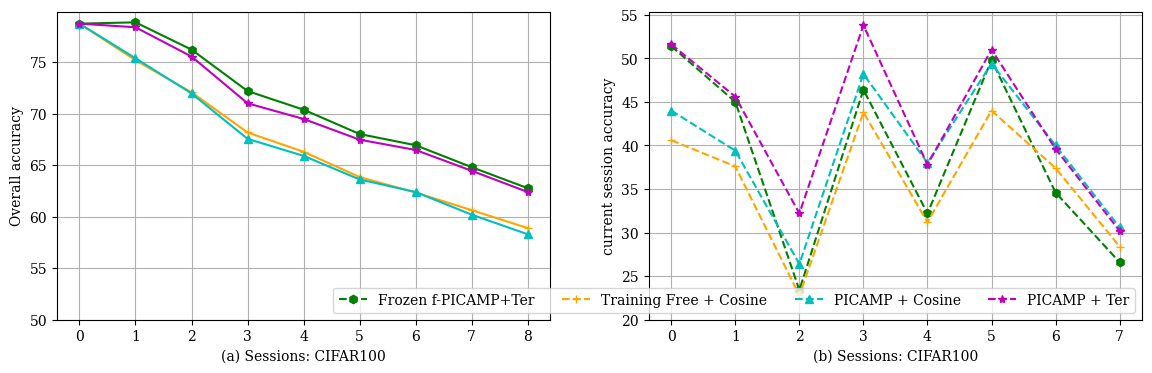

In [148]:
yy = np.array([[78.73, 78.86, 76.21, 72.19, 70.38, 68.02, 66.93, 64.8 , 62.76],#Frozen f
       [78.73, 51.4 , 45.  , 23.4 , 46.4 , 32.2 , 49.8 , 34.6 , 26.6 ],

       [78.73, 75.18, 72.07, 68.17, 66.3 , 63.84, 62.34, 60.63, 58.89], #Frozen f simple cosine
       [78.73, 40.6 , 37.6 , 22.8 , 43.8 , 31.2 , 44.  , 37.4 , 28.4 ],

       [78.73, 75.37, 71.96, 67.55, 65.9 , 63.61, 62.39, 60.19, 58.29], # simple cosine
       [78.73, 44.  , 39.4 , 26.4 , 48.2 , 38.  , 49.4 , 40.  , 30.6 ],

       [78.73, 78.38, 75.54, 71.  , 69.48, 67.47, 66.47, 64.45, 62.39], #PICAMP epoch 10
       [78.73, 51.6 , 45.6 , 32.2 , 53.8 , 37.8 , 51.  , 39.6 , 31.2 ],

      [78.73, 78.35, 75.53, 71.13, 69.44, 67.81, 66.86, 64.72, 62.76], # frozen w
       [78.73, 51.4 , 45.4 , 31.2 , 52.6 , 40.2 , 52.4 , 39.8 , 31.6 ]])

plt.rc('font', family='serif')
plt.figure(figsize=(14,4))
col=['g','orange','c','m']
mark=['h','+','^','*']
ls=['-','--']
plt.subplot(1,2,1)
plt.ylabel("Overall accuracy")
for i in range(0,8,2):
    plt.plot(yy[i],marker=mark[i//2],color=col[i//2])
plt.xlabel("(a) Sessions: CIFAR100")
plt.grid(True)
plt.yticks(np.arange(50, 80, 5))

plt.subplot(1,2,2)
plt.ylabel("current session accuracy")
for i in range(1,8,2):
    plt.plot(yy[i][1:],marker=mark[i//2],linestyle='--',color=col[i//2])
plt.xlabel("(b) Sessions: CIFAR100")
plt.grid(True)
plt.yticks(np.arange(20, 60, 5))
plt.legend(['Frozen f-PICAMP+Ter', 'Training Free + Cosine', 'PICAMP + Cosine','PICAMP + Ter'],ncols=5,loc='lower right')
plt.savefig('setup_variation.pdf', format='pdf', bbox_inches='tight')
plt.show()

Varying sh

Ys

## confusion matrix

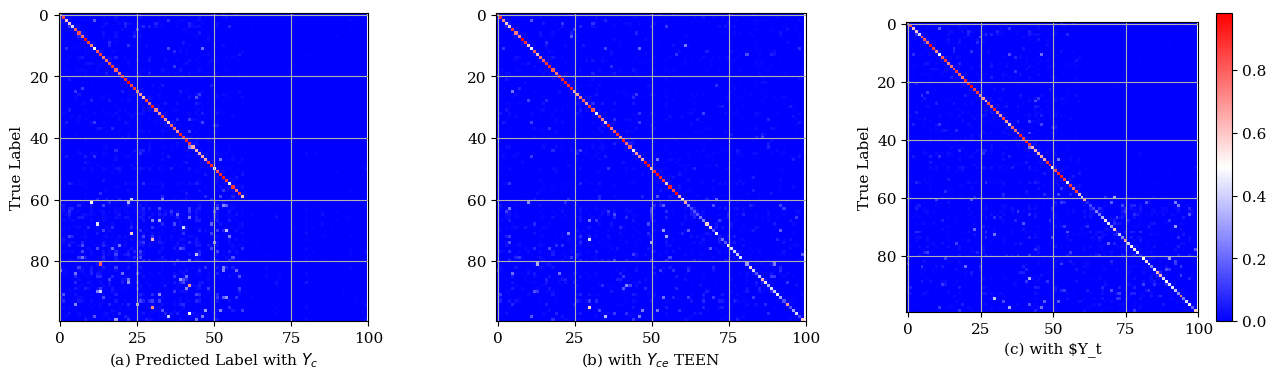

In [169]:
# PICAMP_5_6_cifar_11 = Incremental_train(dbName='cifar100', train_way=5, shot=5,num_batch=10, iteration=1, IncSession=8,teen=1,itr=1,alpha=0.6)
cm2,cm4,cm1,cm3= teen,picamp_yce,picamp_yc,picamp_yt=PICAMP_5_6_cifar_11[1]
positions = [0, 25, 50, 75, 100]
class_labels = [str(p) for p in positions]
plt.figure(figsize=(16,4))
plt.rc('font', family='serif',size=11)

plt.subplot(1,3,1)
cm_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,  cmap = 'bwr', interpolation ='nearest')
plt.xticks(ticks=positions, labels = class_labels)
#plt.yticks(ticks=positions, labels=class_labels)
plt.xlabel('(a) Predicted Label with $Y_c$')
plt.ylabel('True Label')
plt.grid(True)

plt.subplot(1,3,2)
cm_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,  cmap = 'bwr', interpolation ='nearest')
plt.xticks(ticks=positions, labels =class_labels)
#plt.yticks(ticks=positions, labels=class_labels)
plt.xlabel('(b) with $Y_{ce}$ TEEN')
plt.grid(True)

plt.subplot(1,3,3)
cm_normalized = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,  cmap = 'bwr', interpolation ='nearest') #plt.cm.Blues
plt.xticks(ticks=positions, labels = class_labels) #np.arange(cm_normalized.shape[1]), auxProtoLA_1
#plt.yticks(ticks=positions, labels=class_labels)
plt.xlabel('(c) with $Y_t')
plt.ylabel('True Label')
plt.grid(True)

plt.colorbar()
plt.savefig('confusionMatrix.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Accuracy Plot

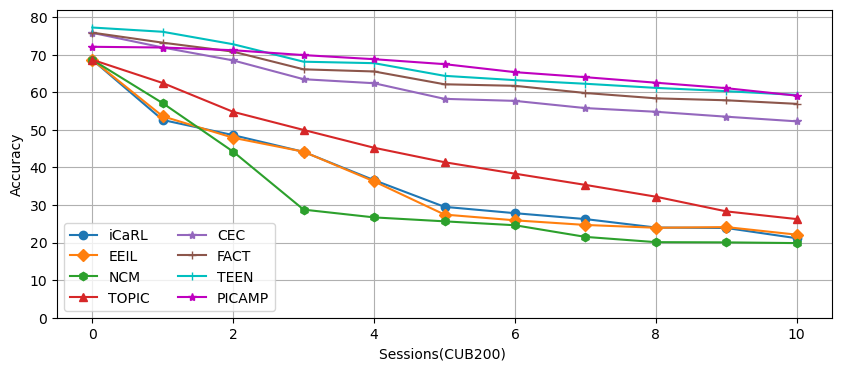

In [ ]:
plt.figure(figsize=(10,4))
#cub200
bx=[ [68.68, 52.65, 48.61, 44.16, 36.62, 29.52, 27.83, 26.26, 24.01, 23.89, 21.16], #Carl
     [68.68, 53.63, 47.91, 44.20, 36.30, 27.46, 25.93, 24.70, 23.95, 24.13, 22.11], #EEIL
     [68.68, 57.12, 44.21, 28.78, 26.71, 25.66, 24.62, 21.52, 20.12, 20.06, 19.87], #Replacing
     [68.68, 62.49, 54.81, 49.99, 45.25, 41.40, 38.35, 35.36, 32.22, 28.31, 26.26], #Topic
     [75.85, 71.94, 68.50, 63.50, 62.43, 58.27, 57.73, 55.81, 54.83, 53.52, 52.28], #CEC
     [75.90, 73.23, 70.84, 66.13, 65.56, 62.15, 61.74, 59.83, 58.41, 57.89, 56.94], #Fact
     [77.26, 76.13, 72.81, 68.16, 67.77, 64.40, 63.25, 62.29, 61.19, 60.32, 59.31], #Teen
     [72.13, 71.94, 71.22, 69.92, 68.83, 67.51, 65.38, 64.04, 62.57, 61.11, 59.12]] #PICAMP

bx1=np.array(bx)
plt.plot(bx1[0], marker='o'); plt.plot(bx1[1], marker='D'); plt.plot(bx1[2], marker='h');
plt.plot(bx1[3], marker='^');plt.plot(bx1[4], marker='*');plt.plot(bx1[5], marker='+');plt.plot(bx1[6], marker='|',color='c'); plt.plot(bx1[7], marker='*',color='m')

#plt.plot(ax1, marker=markers)
plt.legend(['iCaRL','EEIL','NCM','TOPIC','CEC','FACT','TEEN','PICAMP'],loc='lower left',ncols=2)
plt.xlabel('Sessions(CUB200) ')
plt.ylabel('Accuracy')
plt.ylim(0, 82)
plt.grid(True)
plt.savefig('accCUB200_PICAMP.pdf', format='pdf', bbox_inches='tight')

In [ ]:
np.round(np.array([0.8010,0.76024616, 0.72677143, 0.68624001,0.655975 , 0.62698823,0.60195554, 0.57054737, 0.54934 ])*100,2)

array([80.1 , 76.02, 72.68, 68.62, 65.6 , 62.7 , 60.2 , 57.05, 54.93])

In [ ]:
73.6-56.55

17.049999999999997

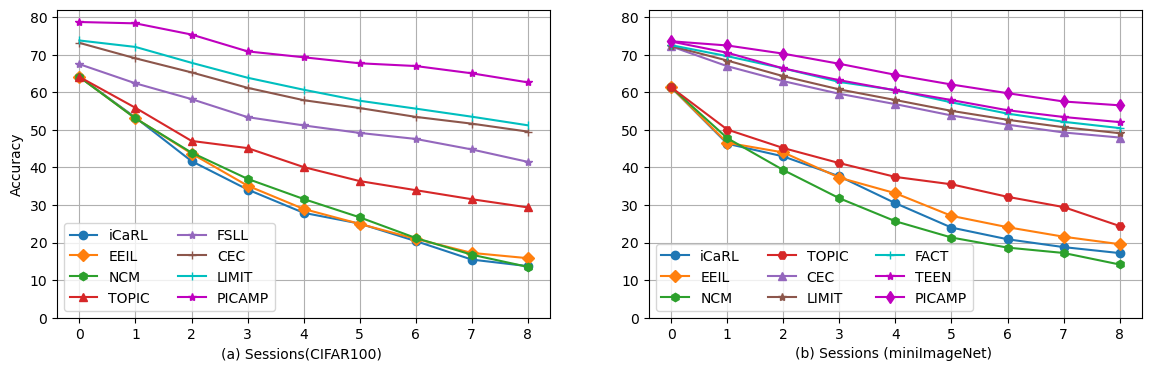

In [ ]:
plt.figure(figsize=(14,4))
#plt.rc('font', family='serif',size=8)#,
#CIFAR100
bx=[[64.10, 53.28, 41.69, 34.13, 27.93, 25.06, 20.41, 15.48, 13.73],  #icarl
    [64.10, 53.11, 43.71, 35.15, 28.96, 24.98, 21.01, 17.26 ,15.85],   #EEIL
    [64.10, 53.05, 43.96, 36.97, 31.61, 26.73, 21.23, 16.78, 13.54],   #Rebalancing
    [64.10, 55.88, 47.07, 45.16, 40.11, 36.38, 33.96, 31.55, 29.37], #TOPIC
    [67.5, 62.4, 58.2, 53.4, 51.2, 49.2, 47.6, 44.8, 41.5], #FSLL
    [73.17, 69.06, 65.31, 61.21, 57.92, 55.82, 53.47, 51.67, 49.55],   #CEC
    [73.81, 72.09, 67.87, 63.89, 60.70, 57.77, 55.67, 53.52, 51.23], #LIMIT
    [78.73, 78.37, 75.39, 70.91, 69.34, 67.74, 67.01, 65.07, 62.66]] #PICAMP upsampling

#MiniImageNet
ax=[[61.31,46.32,42.94,37.63,30.49,24,20.89,18.8,17.21],
[61.31,46.58,44,37.29,33.14,27.12,24.1,21.57,19.58],
[61.31,47.80,39.31,31.8,25.68,21.35,18.67,17.24,14.17],
[61.31,50.09,45.17,41.16,37.48,35.52,32.19,29.46,24.42],

[72.23,66.96,62.98,59.62,56.86,53.85,51.40,49.32,47.97],
[72.32,68.47,64.30,60.78,57.95,55.07,52.70,50.72,49.13],
[72.56,69.63,66.38,62.77,60.6,57.33,54.34,52.16,50.49],
[73.53,70.55,66.37,63.23,60.53,57.95,55.24,53.44,52.08], #TEEN
[73.6 , 72.48, 70.3 , 67.6 , 64.67, 62.09, 59.78, 57.57, 56.55]] #PICAMP
#[75.85,72.8,  69.02, 65.24, 62.65, 60.53, 58.04, 56.07, 54.76]] #PICAMP All


plt.subplot(1,2,1)
bx1=np.array(bx) #.T
plt.plot(bx1[0], marker='o'); plt.plot(bx1[1], marker='D'); plt.plot(bx1[2], marker='h');
plt.plot(bx1[3], marker='^');plt.plot(bx1[4], marker='*');plt.plot(bx1[5], marker='+');plt.plot(bx1[6], marker='|',color='c'); plt.plot(bx1[7], marker='*',color='m')

#plt.plot(ax1, marker=markers)
plt.legend(['iCaRL','EEIL','NCM','TOPIC','FSLL','CEC','LIMIT','PICAMP'],loc='lower left',ncols=2)
plt.xlabel('(a) Sessions(CIFAR100) ')
plt.ylabel('Accuracy')
plt.ylim(0, 82)
plt.grid(True)

plt.subplot(1,2,2)
ax1=np.array(ax) #.T
plt.plot(ax1[0], marker='o'); plt.plot(ax1[1], marker='D'); plt.plot(ax1[2], marker='h');plt.plot(ax1[3], marker='H');
plt.plot(ax1[4], marker='^');plt.plot(ax1[5], marker='*');plt.plot(ax1[6], marker='+',color='c');plt.plot(ax1[7], marker='*',color='m');
plt.plot(ax1[8], marker='d',color='m');

#plt.plot(ax1, marker=markers)
plt.legend(['iCaRL','EEIL','NCM','TOPIC','CEC','LIMIT','FACT','TEEN','PICAMP'],loc='lower left',ncols=3)
plt.xlabel('(b) Sessions (miniImageNet) ')
plt.ylim(0, 82)
plt.grid(True)
plt.savefig('accPICAMP.pdf', format='pdf', bbox_inches='tight')
plt.savefig('accPICAMP.png', format='png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from tensorflow.keras.models import clone_model
resNet = load_model('Model/resnet18_Classifier_Backbone_miniImagemet_50_2.h5')
def create_model_from_config(model, name_suffix):
    # Extract configuration of the original model
    config = model.get_config()
    # Update the names in the configuration
    def update_layer_names(layer_config):
        if 'name' in layer_config:
            layer_config['name'] = layer_config['name'] + f'_{name_suffix}'
        if 'config' in layer_config:
            layer_config['config'] = {k: update_layer_names(v) if isinstance(v, dict) else v for k, v in layer_config['config'].items()}
        return layer_config
    updated_config = update_layer_names(config)
    # Create the new model from the updated configuration
    new_model = Model.from_config(updated_config)
    return new_model
# Example usage
teacher_model = create_model_from_config(resNet, 'teacher')
student_model = create_model_from_config(resNet, 'student')
wT=resNet.get_weights()
teacher_model.set_weights(wT)
student_model.set_weights(wT)

# Testing

In [ ]:
train_way = 5; shot = 1; query=1;
dbName = 'miniImageNet'
resNetClassifier=load_model('Model/resnet18_Classifier_Backbone_'+dbName+'_30_32_50.h5')
mydense=load_model('Model/resnet18_Classifier_mydense_'+dbName+'_30_32_50.h5')
inputs = resNetClassifier.input
pred1 = mydense(resNetClassifier.output)
pred = tf.keras.layers.Activation('softmax')(pred1)
resNetProto = Model(inputs, pred)
optimizer = Adam(learning_rate=0.00001)
resNetProto.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#m4= load_model('Model/resnet18_Classifier_miniImagemet_50_2.h5',custom_objects= {'myDense':myDense})
m4 = resNetProto
#val_loader = Data_GeneratorIncremental(way = train_way,  data ='cipher', k1=0,k2=60, k3=500,k4=600, shot = shot, num_batch=500,all=1)
#val_loader = Data_GeneratorClassifierTest(way = train_way, data ='miniImageNet', k1=0,k2=60, k3=500,k4=600, shot = shot, num_batch=500)

#trainData  = loadData('data/'+dbName+'.pkl');
val_loader= Data_GeneratorClassifier(trainData,way = train_way, k1=0,k2=60, k3=500, k4=600, shot=shot, num_batch= 500)

#val_loader = Data_GeneratorClassifier(trainData,way = train_way,   k1=0,k2=60, k3=500,k4=600, shot = 1, num_batch=500)

result= m4.evaluate(val_loader)
#result= m4.predict(val_loader)
#result= m3.evaluate(val_loader)
#88, 87,85,84, 83,86,85,83,80
#88, 81,82,84, 85,86,85,83,80

#89, 85,83,67, 64,64,34,42,44  #

500/500 [==============================] - 5s 10ms/step - loss: 1.0472 - accuracy: 0.7212
